In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Github/xAI-project-computer-vision

import sys
sys.path.insert(0,'/content/drive/My Drive/Github/xAI-project-computer-vision')

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1Rc4yOY9-4nyo4PuPOLW54tnaNHAfWufd/Github/xAI-project-computer-vision


In [2]:
!pip install torchinfo

In [3]:
import numpy as np
import random
import multiprocessing

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.1.0+cu121
torchvision version: 0.16.0+cu121


In [4]:
import models
from utils import print_model_summary, get_available_device, move_to_device, seed_all

device = get_available_device()
print("Device:", device)

seed_all(42)

Device: cuda

Device: cuda
Random seed 42 has been set.


In [5]:
from datasets import calculate_mean_std

# Load CIFAR-100 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_data = datasets.CIFAR100(root='data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR100(root='data', train=False, download=True, transform=transform)

# Calculate mean and std for normalization
mean_train, std_train = calculate_mean_std(train_data)

# Print mean and std
print(f'mean_train: {mean_train}')
print(f'std_train: {std_train}')

Random seed 42 has been set.
Files already downloaded and verified
Files already downloaded and verified
mean_train: [0.5071, 0.4866, 0.4409]
std_train: [0.2673, 0.2564, 0.2762]


In [6]:
# Default hyperparameters

num_classes = 100

# number of samples per batch to load
batch_size = 64

# number of subprocesses to use for data loading
num_workers = multiprocessing.cpu_count() if not torch.cuda.is_available() else 2
print(f'Number of workers: {num_workers}')

epochs = 10
lr = 0.001
l2 = 0 #0.0001 # L2-norm for weight regularization (weight decay)
grad_clip = None #0.1 #None

# Data augmentation
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train) # NOT mean_test, std_test
])

Number of workers: 2


# Optimization codes

In [ ]:
1.
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(), # p=0.5 by default, which means there's a 50% chance that the image will be horizontally flipped
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

2.
lr=0.0001

3.
l2=0.0001 (default=0)

4.
optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=train_dl.__len__())

5.
grad_clip=0.1 (default=None)

6.
lr=0.01 (default=0.001)

7.
l2=0.00001 (default=0)

8.
batch_size=128 (default=64)

9.
epochs=20 (default=10)

a. optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

b. train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(), # p=0.5 by default, which means there's a 50% chance that the image will be horizontally flipped
    transforms.RandomVerticalFlip(),  # p=0.5 by default
    transforms.GaussianBlur(kernel_size=5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

c. train_transform = transforms.Compose([
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

d. train_transform = transforms.Compose([
    transforms.v2.AutoAugment(transforms.v2.AutoAugmentPolicy.CIFAR10),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(), # p=0.5 by default, which means there's a 50% chance that the image will be horizontally flipped
    transforms.RandomVerticalFlip(),  # p=0.5 by default
    transforms.GaussianBlur(kernel_size=5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

e. train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(), # p=0.5 by default, which means there's a 50% chance that the image will be horizontally flipped
    transforms.RandomVerticalFlip(),  # p=0.5 by default
    transforms.GaussianBlur(kernel_size=5),
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

f. l2 = 0.001

g. train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(), # p=0.5 by default, which means there's a 50% chance that the image will be horizontally flipped
    transforms.ColorJitter(brightness=0.3, hue=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])


h. grad_clip=0.5
i. epochs=30
j. epochs=50
k. l2=0.01

# Train simple custom CNNs

## Train simple custom CNN v1

In [ ]:
# Hyperparameters (optim_code: _9)
epochs = 20

In [ ]:
# Specify model
model = models.get_model('simple_convnet', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
lr_scheduler = None

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
SimpleConvNet (SimpleConvNet)            [64, 3, 32, 32]      [64, 10]             --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 16, 32, 32]     448                  True
├─MaxPool2d (pool)                       [64, 16, 32, 32]     [64, 16, 16, 16]     --                   --
├─Conv2d (conv2)                         [64, 16, 16, 16]     [64, 32, 16, 16]     4,640                True
├─MaxPool2d (pool)                       [64, 32, 16, 16]     [64, 32, 8, 8]       --                   --
├─Conv2d (conv3)                         [64, 32, 8, 8]       [64, 64, 8, 8]       18,496               True
├─MaxPool2d (pool)                       [64, 64, 8, 8]       [64, 64, 4, 4]       --                   --
├─Dropout (dropout)                      [64, 1024]           [64, 1024]           --                   --
├─Linear (fc1)        

Random seed 42 has been set.
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Epoch: 001/020 | Batch 001/625 | Loss: 2.3102
Epoch: 001/020 | Batch 121/625 | Loss: 1.5773
Epoch: 001/020 | Batch 241/625 | Loss: 1.4323
Epoch: 001/020 | Batch 361/625 | Loss: 1.5518
Epoch: 001/020 | Batch 481/625 | Loss: 1.6642
Epoch: 001/020 | Batch 601/625 | Loss: 1.3627
Epoch: 001/020   Train Loss: 1.5022 | Train Acc.: 45.58% | Validation Loss: 1.2358 | Validation Acc.: 55.64%
Validation loss decreased (inf --> 1.2358).  Saving model for epoch 1...
--------------------------------------------------
Epoch: 002/020 | Batch 001/625 | Loss: 1.3399
Epoch: 002/020 | Batch 121/625 | Loss: 1.3220
Epoch: 002/020 | Batch 241/625 | Loss: 1.0375
Epoch: 002/020 | Batch 361/625 | Loss: 1.1585
Epoch: 002/020 | Batch 481/625 | Loss: 0.9330
Epoch: 002/020 | Batch 601/625 | Loss: 1.1751
Epoch: 002/020   Train Loss: 1.1443 | Train Acc.: 59.24% | Validation Loss: 1.050

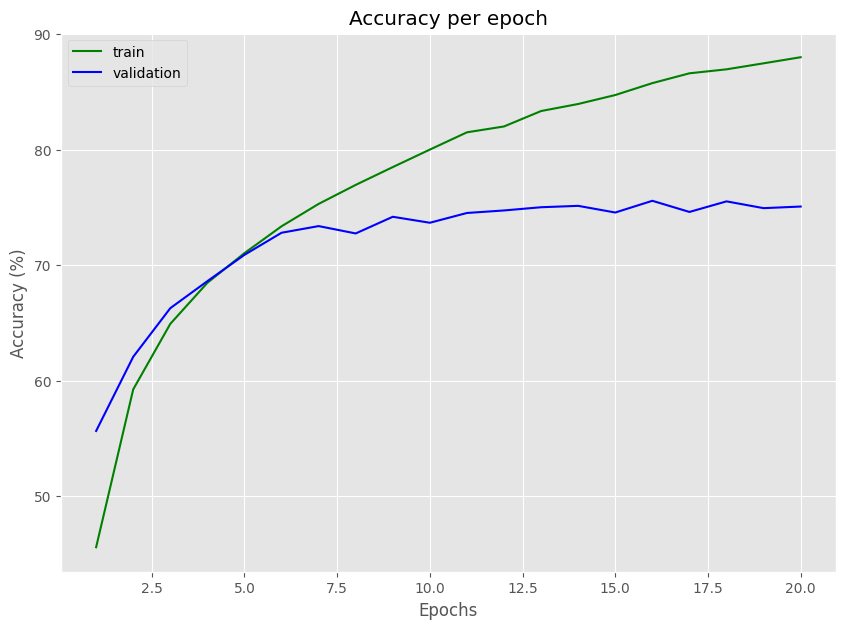

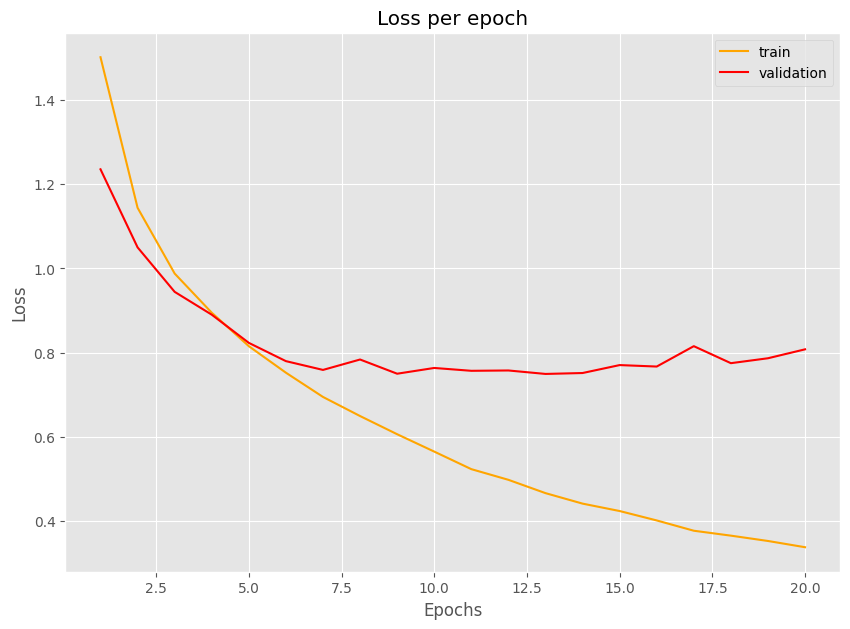

TRAINING FINISHED
CPU times: user 1min 38s, sys: 16.5 s, total: 1min 54s
Wall time: 5min 34s


In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='simple_convnet',
      batch_size=batch_size, num_workers=num_workers, epochs=epochs,
      lr_scheduler=lr_scheduler,
      loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
      train_transform=train_transform, test_transform=test_transform,
      optim_code='_9')

In [ ]:
!python test.py --num_classes 10 --cp_datetime '20240126_001014' --optim_code '_9' --model_name 'simple_convnet' --batch_size 64 --num_workers 2

Random seed 42 has been set.
Device: cuda

Random seed 42 has been set.
Device: cuda

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
SimpleConvNet (SimpleConvNet)            [64, 3, 32, 32]      [64, 10]             --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 16, 32, 32]     448                  True
├─MaxPool2d (pool)                       [64, 16, 32, 32]     [64, 16, 16, 16]     --                   --
├─Conv2d (conv2)                         [64, 16, 16, 16]     [64, 32, 16, 16]     4,640                True
├─MaxPool2d (pool)                       [64, 32, 16, 16]     [64, 32, 8, 8]       --                   --
├─Conv2d (conv3)                         [64, 32, 8, 8]       [64, 64, 8, 8]  

In [ ]:
# Hyperparamter (optim_code: _469)
lr = 0.01
epochs = 20

In [ ]:
# Specify model
model = models.get_model('simple_convnet', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)

from datasets import prepare_data_loaders
train_dl, _ = prepare_data_loaders(num_classes, batch_size, num_workers, train_transform, test_transform)
lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs, steps_per_epoch=train_dl.__len__())

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
SimpleConvNet (SimpleConvNet)            [64, 3, 32, 32]      [64, 10]             --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 16, 32, 32]     448                  True
├─MaxPool2d (pool)                       [64, 16, 32, 32]     [64, 16, 16, 16]     --                   --
├─Conv2d (conv2)                         [64, 16, 16, 16]     [64, 32, 16, 16]     4,640                True
├─MaxPool2d (pool)                       [64, 32, 16, 16]     [64, 32, 8, 8]       --                   --
├─Conv2d (conv3)                         [64, 32, 8, 8]       [64, 64, 8, 8]       18,496               True
├─MaxPool2d (pool)                       [64, 64, 8, 8]       [64, 64, 4, 4]       --                   --
├─Dropout (dropout)                      [64, 1024]           [64, 1024]           --                   --
├─Linear (fc1)        

Random seed 42 has been set.
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Epoch: 001/020 | Batch 001/625 | Loss: 2.3144
Epoch: 001/020 | Batch 121/625 | Loss: 1.7417
Epoch: 001/020 | Batch 241/625 | Loss: 1.5788
Epoch: 001/020 | Batch 361/625 | Loss: 1.6614
Epoch: 001/020 | Batch 481/625 | Loss: 1.6656
Epoch: 001/020 | Batch 601/625 | Loss: 1.6270
Epoch: 001/020   Train Loss: 1.6393 | Train Acc.: 40.45% | Validation Loss: 1.3849 | Validation Acc.: 50.10%
Validation loss decreased (inf --> 1.3849).  Saving model for epoch 1...
--------------------------------------------------
Epoch: 002/020 | Batch 001/625 | Loss: 1.4801
Epoch: 002/020 | Batch 121/625 | Loss: 1.4577
Epoch: 002/020 | Batch 241/625 | Loss: 1.3914
Epoch: 002/020 | Batch 361/625 | Loss: 1.2698
Epoch: 002/020 | Batch 481/625 | Loss: 1.2461
Epoch: 002/020 | Batch 601/625 | Loss: 1.3127
Epoch: 002/020   Train Loss: 1.2987 | Train Acc.: 53.16% | Validation Loss: 1.186

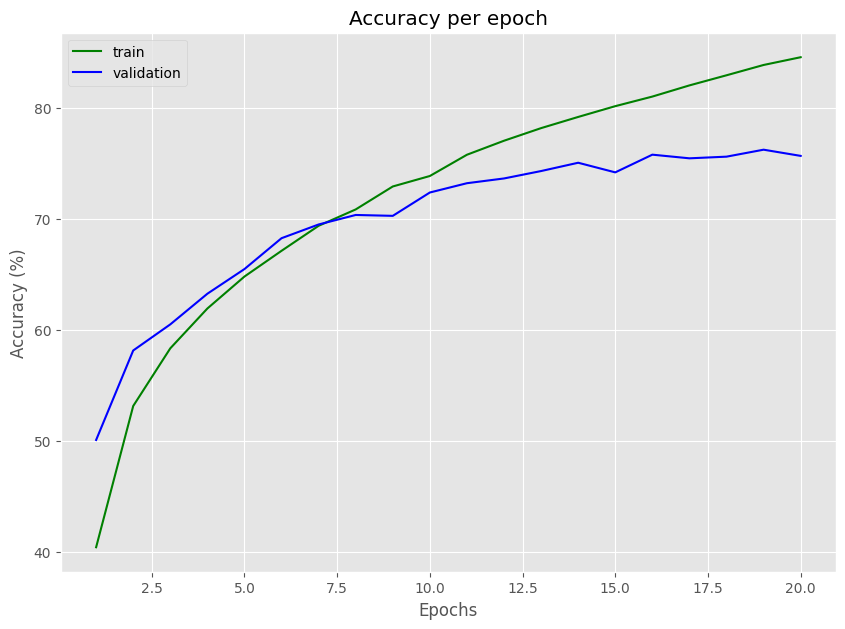

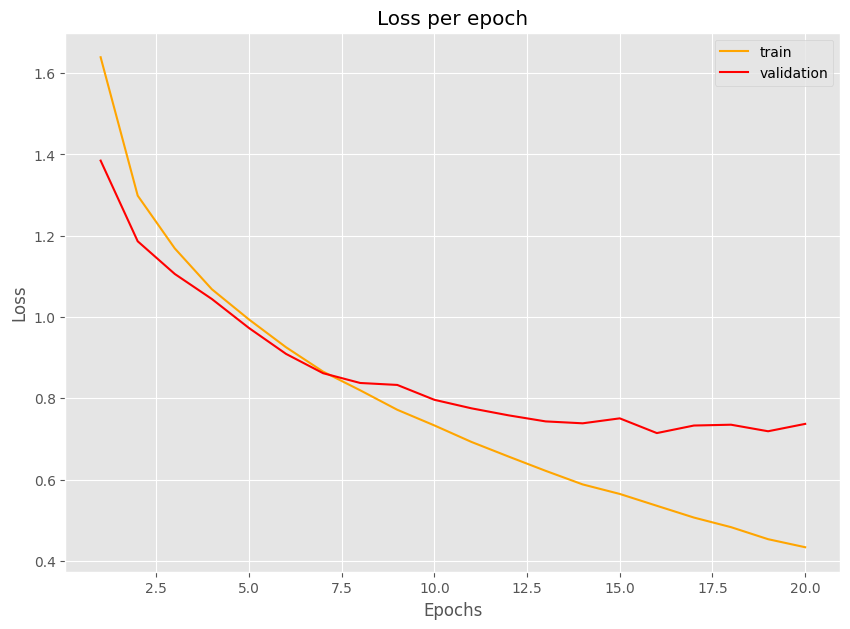

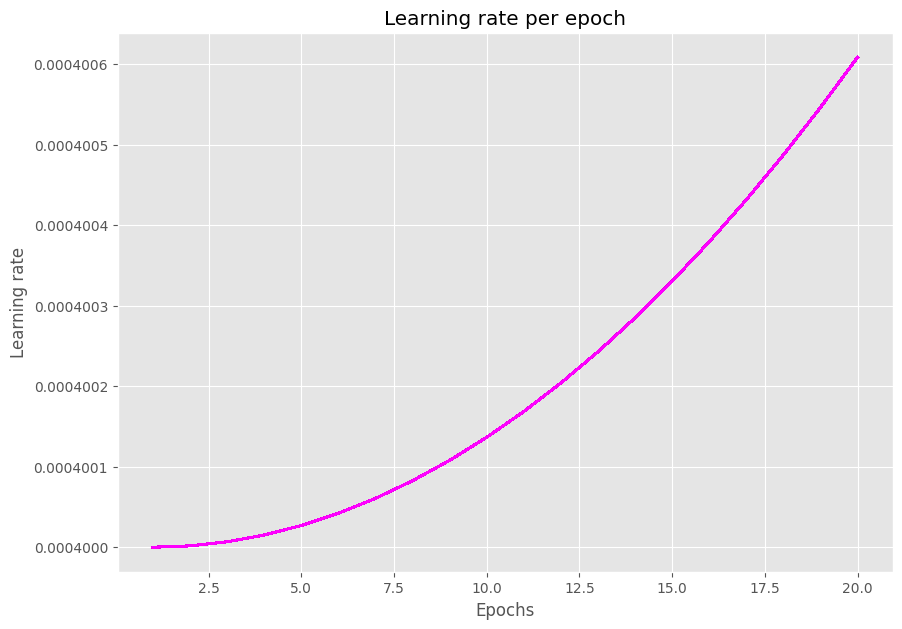

TRAINING FINISHED
CPU times: user 1min 39s, sys: 16.5 s, total: 1min 55s
Wall time: 5min 35s


In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='simple_convnet',
                batch_size=batch_size, num_workers=num_workers, epochs=epochs,
                lr_scheduler=lr_scheduler,
                loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
                train_transform=train_transform, test_transform=test_transform,
                optim_code='_469')

In [ ]:
!python test.py --num_classes 10 --cp_datetime '20240125_235338' --optim_code '_469' --model_name 'simple_convnet' --batch_size 64 --num_workers 2

Random seed 42 has been set.
Device: cuda

Random seed 42 has been set.
Device: cuda

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
SimpleConvNet (SimpleConvNet)            [64, 3, 32, 32]      [64, 10]             --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 16, 32, 32]     448                  True
├─MaxPool2d (pool)                       [64, 16, 32, 32]     [64, 16, 16, 16]     --                   --
├─Conv2d (conv2)                         [64, 16, 16, 16]     [64, 32, 16, 16]     4,640                True
├─MaxPool2d (pool)                       [64, 32, 16, 16]     [64, 32, 8, 8]       --                   --
├─Conv2d (conv3)                         [64, 32, 8, 8]       [64, 64, 8, 8]  

In [ ]:
# Hyperparameters (optim_code: _1359)
epochs = 20
l2 = 0.0001 # L2-norm for weight regularization (weight decay)
grad_clip = 0.1 #None

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(), # p=0.5 by default, which means there's a 50% chance that the image will be horizontally flipped
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_test, std_test),
])

In [ ]:
# Specify model
model = models.get_model('simple_convnet', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
lr_scheduler = None

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
SimpleConvNet (SimpleConvNet)            [64, 3, 32, 32]      [64, 100]            --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 16, 32, 32]     448                  True
├─MaxPool2d (pool)                       [64, 16, 32, 32]     [64, 16, 16, 16]     --                   --
├─Conv2d (conv2)                         [64, 16, 16, 16]     [64, 32, 16, 16]     4,640                True
├─MaxPool2d (pool)                       [64, 32, 16, 16]     [64, 32, 8, 8]       --                   --
├─Conv2d (conv3)                         [64, 32, 8, 8]       [64, 64, 8, 8]       18,496               True
├─MaxPool2d (pool)                       [64, 64, 8, 8]       [64, 64, 4, 4]       --                   --
├─Linear (fc1)                           [64, 1024]           [64, 512]            524,800              True
├─Dropout (dropout) 

Random seed 42 has been set.
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Epoch: 001/020 | Batch 001/625 | Loss: 4.5966
Epoch: 001/020 | Batch 121/625 | Loss: 4.3550
Epoch: 001/020 | Batch 241/625 | Loss: 3.9997
Epoch: 001/020 | Batch 361/625 | Loss: 4.2330
Epoch: 001/020 | Batch 481/625 | Loss: 3.8303
Epoch: 001/020 | Batch 601/625 | Loss: 3.6417
Epoch: 001/020   Train Loss: 4.1153 | Train Acc.: 5.76% | Validation Loss: 3.7125 | Validation Acc.: 11.32%
Validation loss decreased (inf --> 3.7125).  Saving model for epoch 1...
--------------------------------------------------
Epoch: 002/020 | Batch 001/625 | Loss: 3.7797
Epoch: 002/020 | Batch 121/625 | Loss: 3.8125
Epoch: 002/020 | Batch 241/625 | Loss: 3.8375
Epoch: 002/020 | Batch 361/625 | Loss: 3.7276
Epoch: 002/020 | Batch 481/625 | Loss: 3.2615
Epoch: 002/020 | Batch 601/625 | Loss: 3.5462
Epoch: 002/020   Train Loss: 3.6088 | Train Acc.: 13.39% | Validation Loss: 3.3770

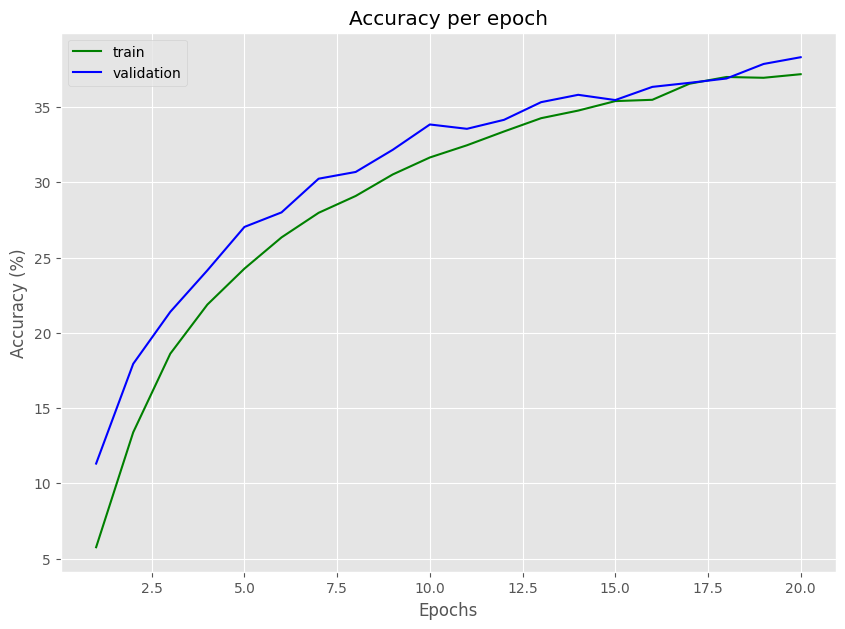

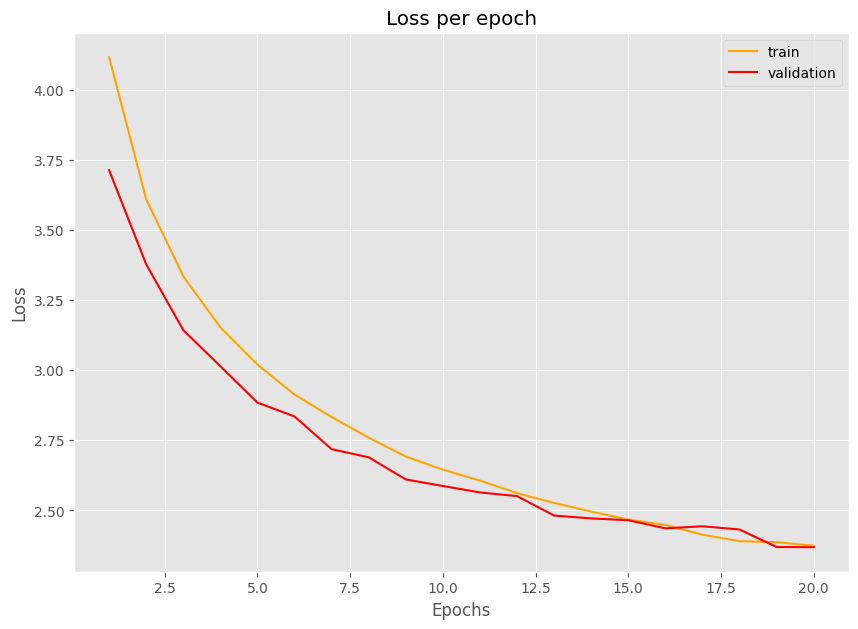

TRAINING FINISHED
CPU times: user 1min 38s, sys: 16.3 s, total: 1min 54s
Wall time: 7min 27s


In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='simple_convnet',
                batch_size=batch_size, num_workers=num_workers, epochs=epochs,
                lr_scheduler=lr_scheduler,
                loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
                train_transform=train_transform, test_transform=test_transform,
                optim_code='_1359')

In [ ]:
!python test.py --num_classes 100 --cp_datetime '20240202_233818' --optim_code '_1359' --model_name 'simple_convnet' --batch_size 64 --num_workers 2

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs
Random seed 42 has been set.
Device: cuda

Random seed 42 has been set.
Device: cuda

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
SimpleConvNet (SimpleConvNet)            [64, 3, 32, 32]      [64, 100]            --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 16, 32, 32]     448                  True
├─MaxPool2d (pool)                       [64, 16, 32, 32]     [64, 16, 16, 16]     --                   --
├─Conv2d (conv2)                         [64, 16, 16, 16]     [64, 32, 16, 16]     4,640                True
├─MaxPool2d (pool)                       [64, 32, 16, 16]     [64, 32, 8, 8]       --                   --
├─Conv2d (conv

## Train simple custom CNN v2

In [ ]:
# Hyperparameters (optim_code: _12359)
epochs = 20
lr = 0.0001
l2 = 0.0001 # L2-norm for weight regularization (weight decay)
grad_clip = 0.1

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(), # p=0.5 by default, which means there's a 50% chance that the image will be horizontally flipped
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

In [ ]:
# Specify model
model = models.get_model('simple_convnet_v2', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
lr_scheduler = None

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
SimpleConvNetV2 (SimpleConvNetV2)        [64, 3, 32, 32]      [64, 100]            --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 48, 32, 32]     1,344                True
├─Conv2d (conv2)                         [64, 48, 32, 32]     [64, 96, 32, 32]     41,568               True
├─MaxPool2d (pool)                       [64, 96, 32, 32]     [64, 96, 16, 16]     --                   --
├─Dropout (dropout)                      [64, 96, 16, 16]     [64, 96, 16, 16]     --                   --
├─Conv2d (conv3)                         [64, 96, 16, 16]     [64, 192, 16, 16]    166,080              True
├─Conv2d (conv4)                         [64, 192, 16, 16]    [64, 256, 16, 16]    442,624              True
├─MaxPool2d (pool)                       [64, 256, 16, 16]    [64, 256, 8, 8]      --                   --
├─Dropout (dropout) 

Random seed 42 has been set.
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Epoch: 001/020 | Batch 001/625 | Loss: 4.6108
Epoch: 001/020 | Batch 121/625 | Loss: 4.5765
Epoch: 001/020 | Batch 241/625 | Loss: 4.3692
Epoch: 001/020 | Batch 361/625 | Loss: 4.3686
Epoch: 001/020 | Batch 481/625 | Loss: 4.2129
Epoch: 001/020 | Batch 601/625 | Loss: 4.0487
Epoch: 001/020   Train Loss: 4.3997 | Train Acc.: 3.97% | Validation Loss: 4.0748 | Validation Acc.: 8.30%
Validation loss decreased (inf --> 4.0748).  Saving model for epoch 1...
--------------------------------------------------
Epoch: 002/020 | Batch 001/625 | Loss: 4.1981
Epoch: 002/020 | Batch 121/625 | Loss: 4.1975
Epoch: 002/020 | Batch 241/625 | Loss: 4.0603
Epoch: 002/020 | Batch 361/625 | Loss: 4.1788
Epoch: 002/020 | Batch 481/625 | Loss: 3.9411
Epoch: 002/020 | Batch 601/625 | Loss: 4.0890
Epoch: 002/020   Train Loss: 4.0590 | Train Acc.: 7.56% | Validation Loss: 3.8336 |

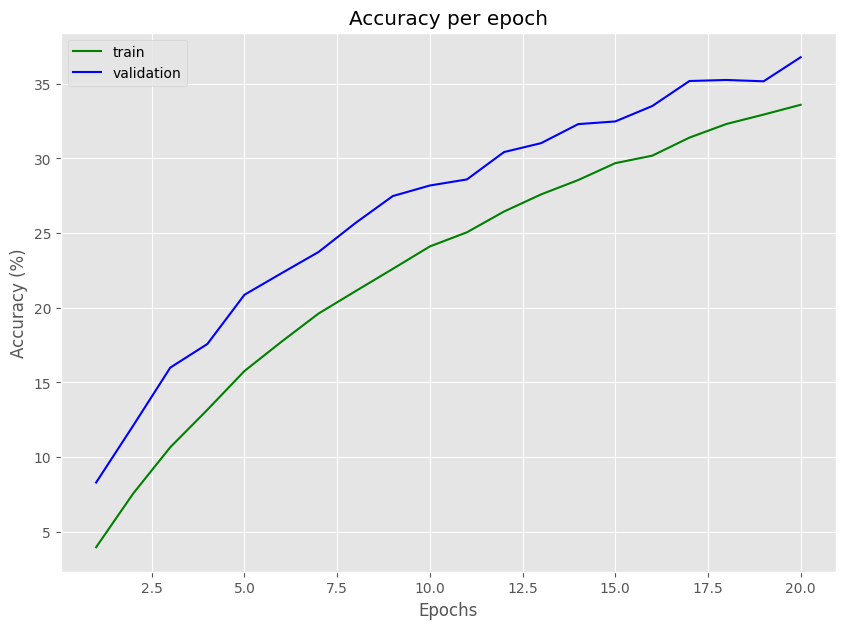

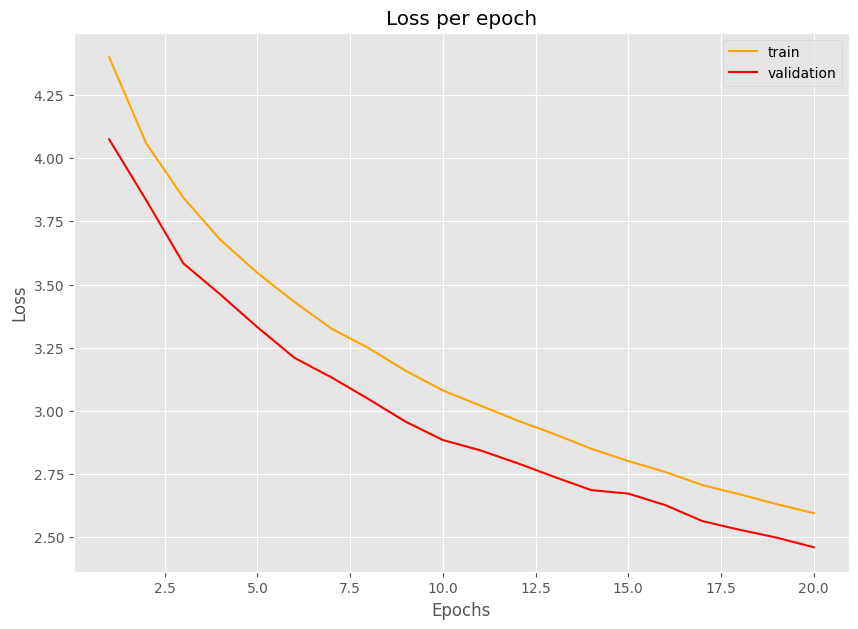

TRAINING FINISHED
CPU times: user 3min 21s, sys: 19.1 s, total: 3min 40s
Wall time: 8min 59s


In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='simple_convnet_v2',
      batch_size=batch_size, num_workers=num_workers, epochs=epochs,
      lr_scheduler=lr_scheduler,
      loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
      train_transform=train_transform, test_transform=test_transform,
      optim_code='_12359')

In [ ]:
!python test.py --num_classes 100 --cp_datetime '20240126_135550' --optim_code '_12359' --model_name 'simple_convnet_v2' --batch_size 64 --num_workers 2

Random seed 42 has been set.
Device: cuda

Random seed 42 has been set.
Device: cuda

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
SimpleConvNetV2 (SimpleConvNetV2)        [64, 3, 32, 32]      [64, 100]            --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 48, 32, 32]     1,344                True
├─Conv2d (conv2)                         [64, 48, 32, 32]     [64, 96, 32, 32]     41,568               True
├─MaxPool2d (pool)                       [64, 96, 32, 32]     [64, 96, 16, 16]     --                   --
├─Dropout (dropout)                      [64, 96, 16, 16]     [64, 96, 16, 16]     --                   --
├─Conv2d (conv3)                         [64, 96, 16, 16]     [64, 192, 16, 16

# Train deeper custom CNNs (based on ResNet)

## Train simplified custom ResNet

In [ ]:
# TOP
# Hyperparameters (optim_code: _1359)
epochs = 20
l2 = 0.0001 # L2-norm for weight regularization (weight decay)
grad_clip = 0.1

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(), # p=0.5 by default, which means there's a 50% chance that the image will be horizontally flipped
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

In [ ]:
# Specify model
model = models.get_model('resnet_custom_simplified', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
lr_scheduler = None

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ResnetCustomSimplified (ResnetCustomSimplified)    [64, 3, 32, 32]      [64, 100]            --                   True
├─Sequential (conv_layer_1)                        [64, 3, 32, 32]      [64, 64, 32, 32]     --                   True
│    └─Conv2d (0)                                  [64, 3, 32, 32]      [64, 64, 32, 32]     1,792                True
│    └─BatchNorm2d (1)                             [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
│    └─ReLU (2)                                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   --
├─Sequential (conv_layer_2)                        [64, 64, 32, 32]     [64, 128, 16, 16]    --                   True
│    └─Conv2d (0)                                  [64, 64, 32, 32]     [64, 128, 32, 32]    73,856               True
│    └─BatchNorm2d (1)                       

Random seed 42 has been set.
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Epoch: 001/020 | Batch 001/625 | Loss: 5.0638
Epoch: 001/020 | Batch 121/625 | Loss: 4.7971
Epoch: 001/020 | Batch 241/625 | Loss: 4.1280
Epoch: 001/020 | Batch 361/625 | Loss: 4.3810
Epoch: 001/020 | Batch 481/625 | Loss: 3.5834
Epoch: 001/020 | Batch 601/625 | Loss: 3.5323
Epoch: 001/020   Train Loss: 4.4575 | Train Acc.: 6.32% | Validation Loss: 3.6636 | Validation Acc.: 12.74%
Validation loss decreased (inf --> 3.6636).  Saving model for epoch 1...
--------------------------------------------------
Epoch: 002/020 | Batch 001/625 | Loss: 3.5930
Epoch: 002/020 | Batch 121/625 | Loss: 3.2810
Epoch: 002/020 | Batch 241/625 | Loss: 3.7213
Epoch: 002/020 | Batch 361/625 | Loss: 3.2541
Epoch: 002/020 | Batch 481/625 | Loss: 2.6785
Epoch: 002/020 | Batch 601/625 | Loss: 2.9155
Epoch: 002/020   Train Loss: 3.3046 | Train Acc.: 19.25% | Validation Loss: 3.2167

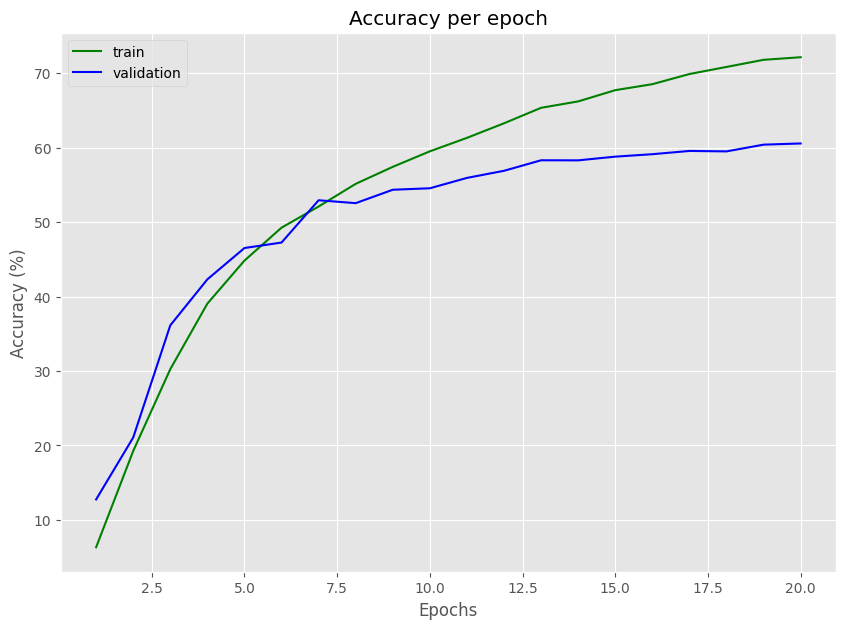

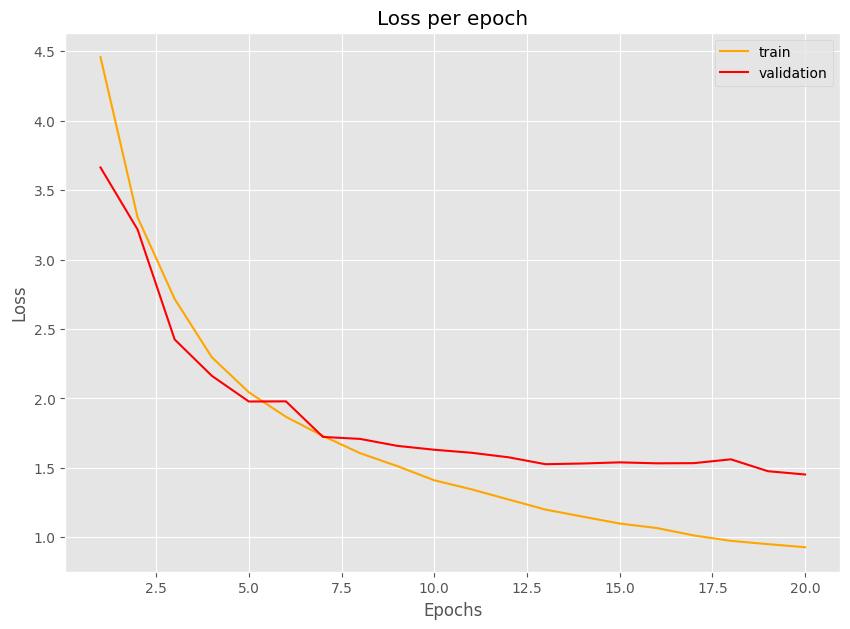

TRAINING FINISHED
CPU times: user 5min 40s, sys: 20 s, total: 6min
Wall time: 11min 1s


In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='resnet_custom_simplified',
      batch_size=batch_size, num_workers=num_workers, epochs=epochs,
      lr_scheduler=lr_scheduler,
      loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
      train_transform=train_transform, test_transform=test_transform,
      optim_code='_1359')

In [ ]:
!python test.py --num_classes 100 --cp_datetime '20240130_143121' --optim_code '_1359' --model_name 'resnet_custom_simplified' --batch_size 64 --num_workers 2

Random seed 42 has been set.
Device: cuda

Random seed 42 has been set.
Device: cuda

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ResnetCustomSimplified (ResnetCustomSimplified)    [64, 3, 32, 32]      [64, 100]            --                   True
├─Sequential (conv_layer_1)                        [64, 3, 32, 32]      [64, 64, 32, 32]     --                   True
│    └─Conv2d (0)                                  [64, 3, 32, 32]      [64, 64, 32, 32]     1,792                True
│    └─BatchNorm2d (1)                             [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
│    └─ReLU (2)                                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   --
├─Sequential (co

In [ ]:
# Hyperparameters (optim_code: _135i)
epochs = 30
l2 = 0.0001 # L2-norm for weight regularization (weight decay)
grad_clip = 0.1

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(), # p=0.5 by default, which means there's a 50% chance that the image will be horizontally flipped
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

In [ ]:
# Specify model
model = models.get_model('resnet_custom_simplified', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
lr_scheduler = None

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ResnetCustomSimplified (ResnetCustomSimplified)    [64, 3, 32, 32]      [64, 100]            --                   True
├─Sequential (conv_layer_1)                        [64, 3, 32, 32]      [64, 64, 32, 32]     --                   True
│    └─Conv2d (0)                                  [64, 3, 32, 32]      [64, 64, 32, 32]     1,792                True
│    └─BatchNorm2d (1)                             [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
│    └─ReLU (2)                                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   --
├─Sequential (conv_layer_2)                        [64, 64, 32, 32]     [64, 128, 16, 16]    --                   True
│    └─Conv2d (0)                                  [64, 64, 32, 32]     [64, 128, 32, 32]    73,856               True
│    └─BatchNorm2d (1)                       

Random seed 42 has been set.
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Epoch: 001/030 | Batch 001/625 | Loss: 4.9507
Epoch: 001/030 | Batch 121/625 | Loss: 4.6809
Epoch: 001/030 | Batch 241/625 | Loss: 4.1203
Epoch: 001/030 | Batch 361/625 | Loss: 4.3022
Epoch: 001/030 | Batch 481/625 | Loss: 3.7845
Epoch: 001/030 | Batch 601/625 | Loss: 3.7640
Epoch: 001/030   Train Loss: 4.4345 | Train Acc.: 5.96% | Validation Loss: 3.7401 | Validation Acc.: 11.61%
Validation loss decreased (inf --> 3.7401).  Saving model for epoch 1...
--------------------------------------------------
Epoch: 002/030 | Batch 001/625 | Loss: 3.7864
Epoch: 002/030 | Batch 121/625 | Loss: 3.5681
Epoch: 002/030 | Batch 241/625 | Loss: 3.7962
Epoch: 002/030 | Batch 361/625 | Loss: 3.3784
Epoch: 002/030 | Batch 481/625 | Loss: 3.0117
Epoch: 002/030 | Batch 601/625 | Loss: 3.1933
Epoch: 002/030   Train Loss: 3.4687 | Train Acc.: 16.47% | Validation Loss: 3.1388

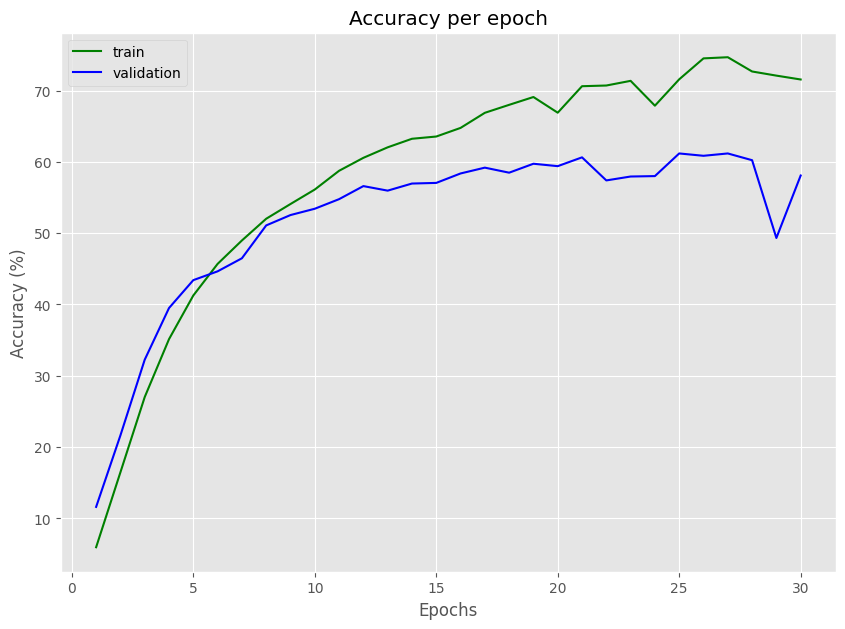

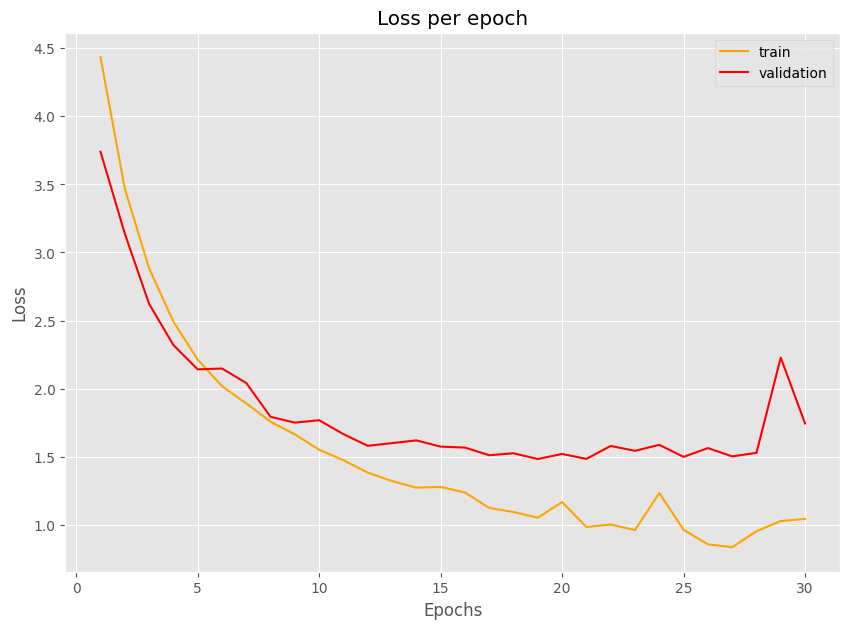

TRAINING FINISHED
CPU times: user 8min 51s, sys: 25.9 s, total: 9min 17s
Wall time: 14min 59s


In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='resnet_custom_simplified',
      batch_size=batch_size, num_workers=num_workers, epochs=epochs,
      lr_scheduler=lr_scheduler,
      loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
      train_transform=train_transform, test_transform=test_transform,
      optim_code='_135i')

In [ ]:
!python test.py --num_classes 100 --cp_datetime '20240203_002700' --optim_code '_135i' --model_name 'resnet_custom_simplified' --batch_size 64 --num_workers 2

Random seed 42 has been set.
Device: cuda

Random seed 42 has been set.
Device: cuda

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ResnetCustomSimplified (ResnetCustomSimplified)    [64, 3, 32, 32]      [64, 100]            --                   True
├─Sequential (conv_layer_1)                        [64, 3, 32, 32]      [64, 64, 32, 32]     --                   True
│    └─Conv2d (0)                                  [64, 3, 32, 32]      [64, 64, 32, 32]     1,792                True
│    └─BatchNorm2d (1)                             [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
│    └─ReLU (2)                                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   --
├─Sequential (co

In [ ]:
# Hyperparameters (optim_code: _13hi)
epochs = 30
l2 = 0.0001 # L2-norm for weight regularization (weight decay)
grad_clip = 0.5

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(), # p=0.5 by default, which means there's a 50% chance that the image will be horizontally flipped
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

In [ ]:
# Specify model
model = models.get_model('resnet_custom_simplified', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
lr_scheduler = None

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ResnetCustomSimplified (ResnetCustomSimplified)    [64, 3, 32, 32]      [64, 100]            --                   True
├─Sequential (conv_layer_1)                        [64, 3, 32, 32]      [64, 64, 32, 32]     --                   True
│    └─Conv2d (0)                                  [64, 3, 32, 32]      [64, 64, 32, 32]     1,792                True
│    └─BatchNorm2d (1)                             [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
│    └─ReLU (2)                                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   --
├─Sequential (conv_layer_2)                        [64, 64, 32, 32]     [64, 128, 16, 16]    --                   True
│    └─Conv2d (0)                                  [64, 64, 32, 32]     [64, 128, 32, 32]    73,856               True
│    └─BatchNorm2d (1)                       

Random seed 42 has been set.
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Epoch: 001/030 | Batch 001/625 | Loss: 5.0638
Epoch: 001/030 | Batch 121/625 | Loss: 4.9114
Epoch: 001/030 | Batch 241/625 | Loss: 4.1206
Epoch: 001/030 | Batch 361/625 | Loss: 4.3851
Epoch: 001/030 | Batch 481/625 | Loss: 3.5667
Epoch: 001/030 | Batch 601/625 | Loss: 3.5816
Epoch: 001/030   Train Loss: 4.4737 | Train Acc.: 6.17% | Validation Loss: 3.6386 | Validation Acc.: 12.56%
Validation loss decreased (inf --> 3.6386).  Saving model for epoch 1...
--------------------------------------------------
Epoch: 002/030 | Batch 001/625 | Loss: 3.5611
Epoch: 002/030 | Batch 121/625 | Loss: 3.3769
Epoch: 002/030 | Batch 241/625 | Loss: 3.7672
Epoch: 002/030 | Batch 361/625 | Loss: 3.2468
Epoch: 002/030 | Batch 481/625 | Loss: 2.7158
Epoch: 002/030 | Batch 601/625 | Loss: 2.9991
Epoch: 002/030   Train Loss: 3.3048 | Train Acc.: 19.29% | Validation Loss: 3.0919

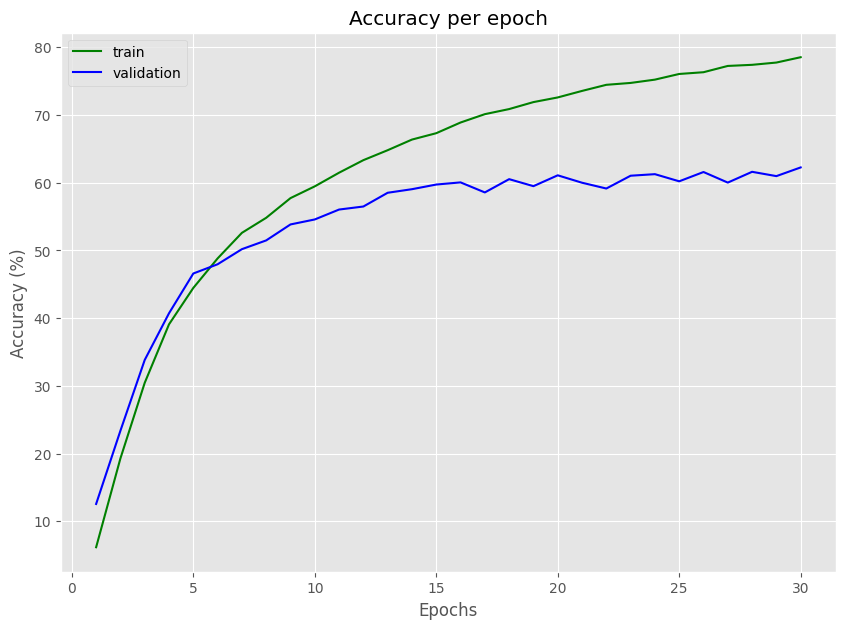

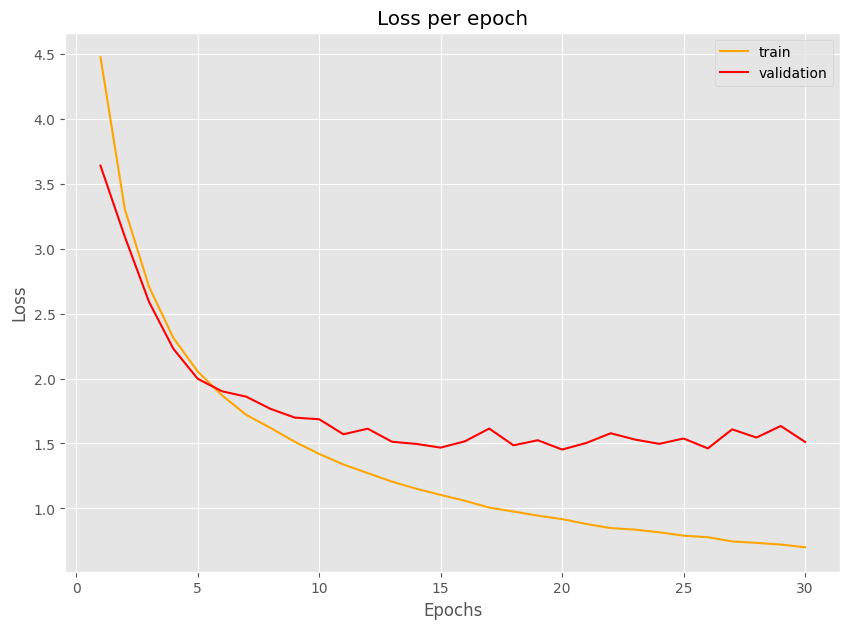

TRAINING FINISHED
CPU times: user 8min 34s, sys: 28.7 s, total: 9min 3s
Wall time: 16min 23s


In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='resnet_custom_simplified',
      batch_size=batch_size, num_workers=num_workers, epochs=epochs,
      lr_scheduler=lr_scheduler,
      loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
      train_transform=train_transform, test_transform=test_transform,
      optim_code='_13hi')

In [ ]:
!python test.py --num_classes 100 --cp_datetime '20240130_141052' --optim_code '_13hi' --model_name 'resnet_custom_simplified' --batch_size 64 --num_workers 2

Random seed 42 has been set.
Device: cuda

Random seed 42 has been set.
Device: cuda

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ResnetCustomSimplified (ResnetCustomSimplified)    [64, 3, 32, 32]      [64, 100]            --                   True
├─Sequential (conv_layer_1)                        [64, 3, 32, 32]      [64, 64, 32, 32]     --                   True
│    └─Conv2d (0)                                  [64, 3, 32, 32]      [64, 64, 32, 32]     1,792                True
│    └─BatchNorm2d (1)                             [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
│    └─ReLU (2)                                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   --
├─Sequential (co

In [ ]:
# Hyperparameters (optim_code: _159k)
epochs = 20
l2 = 0.01 # L2-norm for weight regularization (weight decay)
grad_clip = 0.1

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(), # p=0.5 by default, which means there's a 50% chance that the image will be horizontally flipped
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

In [ ]:
# Specify model
model = models.get_model('resnet_custom_simplified', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
lr_scheduler = None

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ResnetCustomSimplified (ResnetCustomSimplified)    [64, 3, 32, 32]      [64, 100]            --                   True
├─Sequential (conv_layer_1)                        [64, 3, 32, 32]      [64, 64, 32, 32]     --                   True
│    └─Conv2d (0)                                  [64, 3, 32, 32]      [64, 64, 32, 32]     1,792                True
│    └─BatchNorm2d (1)                             [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
│    └─ReLU (2)                                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   --
├─Sequential (conv_layer_2)                        [64, 64, 32, 32]     [64, 128, 16, 16]    --                   True
│    └─Conv2d (0)                                  [64, 64, 32, 32]     [64, 128, 32, 32]    73,856               True
│    └─BatchNorm2d (1)                       

Random seed 42 has been set.
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Epoch: 001/020 | Batch 001/625 | Loss: 5.0638
Epoch: 001/020 | Batch 121/625 | Loss: 4.7267
Epoch: 001/020 | Batch 241/625 | Loss: 4.3113
Epoch: 001/020 | Batch 361/625 | Loss: 4.4732
Epoch: 001/020 | Batch 481/625 | Loss: 3.7402
Epoch: 001/020 | Batch 601/625 | Loss: 3.8883
Epoch: 001/020   Train Loss: 4.5527 | Train Acc.: 4.66% | Validation Loss: 4.1139 | Validation Acc.: 6.97%
Validation loss decreased (inf --> 4.1139).  Saving model for epoch 1...
--------------------------------------------------
Epoch: 002/020 | Batch 001/625 | Loss: 3.8735
Epoch: 002/020 | Batch 121/625 | Loss: 3.6945
Epoch: 002/020 | Batch 241/625 | Loss: 4.0920
Epoch: 002/020 | Batch 361/625 | Loss: 3.6844
Epoch: 002/020 | Batch 481/625 | Loss: 3.1322
Epoch: 002/020 | Batch 601/625 | Loss: 3.5167
Epoch: 002/020   Train Loss: 3.6814 | Train Acc.: 12.54% | Validation Loss: 3.8568 

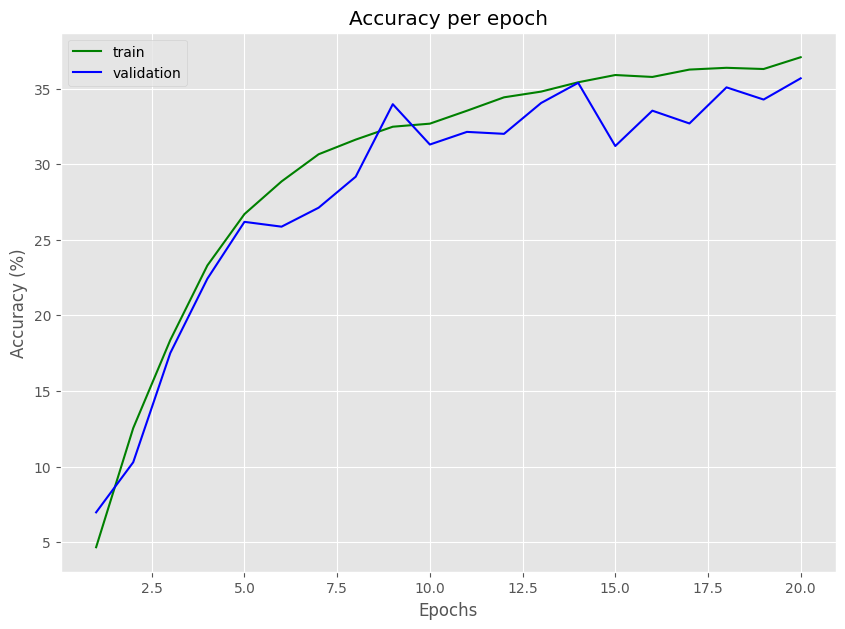

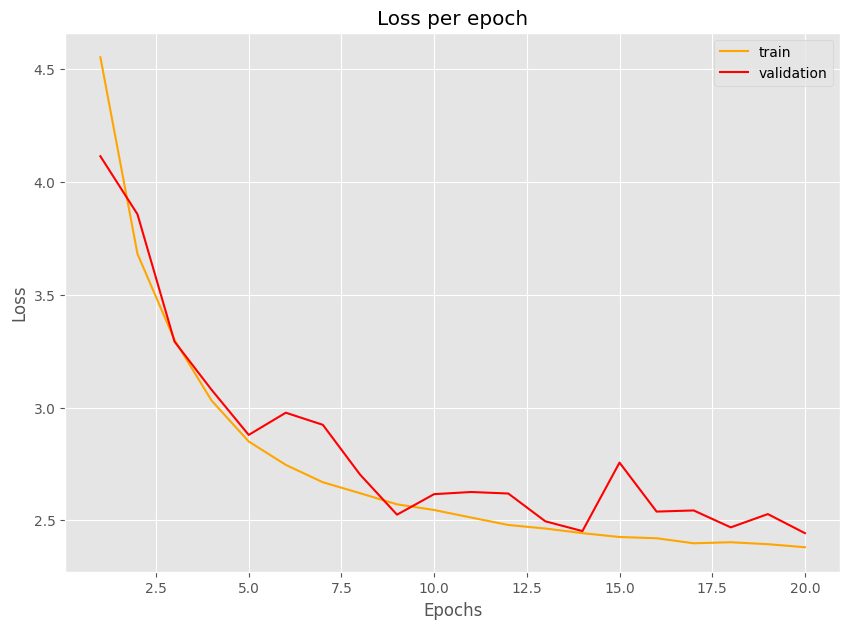

TRAINING FINISHED
CPU times: user 5min 49s, sys: 18 s, total: 6min 7s
Wall time: 9min 51s


In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='resnet_custom_simplified',
      batch_size=batch_size, num_workers=num_workers, epochs=epochs,
      lr_scheduler=lr_scheduler,
      loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
      train_transform=train_transform, test_transform=test_transform,
      optim_code='_159k')

In [ ]:
!python test.py --num_classes 100 --cp_datetime '20240203_004447' --optim_code '_159k' --model_name 'resnet_custom_simplified' --batch_size 64 --num_workers 2

Random seed 42 has been set.
Device: cuda

Random seed 42 has been set.
Device: cuda

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ResnetCustomSimplified (ResnetCustomSimplified)    [64, 3, 32, 32]      [64, 100]            --                   True
├─Sequential (conv_layer_1)                        [64, 3, 32, 32]      [64, 64, 32, 32]     --                   True
│    └─Conv2d (0)                                  [64, 3, 32, 32]      [64, 64, 32, 32]     1,792                True
│    └─BatchNorm2d (1)                             [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
│    └─ReLU (2)                                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   --
├─Sequential (co

## Train custom ResNet18

In [ ]:
# TOP
# Hyperparameters (optim_code: _1359)
epochs = 20
l2 = 0.0001 # L2-norm for weight regularization (weight decay)
grad_clip = 0.1

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(), # p=0.5 by default, which means there's a 50% chance that the image will be horizontally flipped
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

In [ ]:
# Specify model
model = models.get_model('resnet18_custom', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
lr_scheduler = None

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 32, 32]      [64, 100]            --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 64, 32, 32]     1,728                True
├─BatchNorm2d (bn1)                      [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
├─Sequential (layer1)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    └─BasicBlock (0)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    │    └─Conv2d (conv1)               [64, 64, 32, 32]     [64, 64, 32, 32]     36,864               True
│    │    └─BatchNorm2d (bn1)            [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
│    │    └─Conv2d (conv2)               [64, 64, 32, 32]     [64, 64, 32, 32]     36,864               True
│    │    └─Ba

Random seed 42 has been set.
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Epoch: 001/020 | Batch 001/625 | Loss: 4.6400
Epoch: 001/020 | Batch 121/625 | Loss: 4.2956
Epoch: 001/020 | Batch 241/625 | Loss: 3.9449
Epoch: 001/020 | Batch 361/625 | Loss: 4.1979
Epoch: 001/020 | Batch 481/625 | Loss: 3.7517
Epoch: 001/020 | Batch 601/625 | Loss: 3.6600
Epoch: 001/020   Train Loss: 4.0620 | Train Acc.: 7.01% | Validation Loss: 3.6884 | Validation Acc.: 11.72%
Validation loss decreased (inf --> 3.6884).  Saving model for epoch 1...
--------------------------------------------------
Epoch: 002/020 | Batch 001/625 | Loss: 3.6849
Epoch: 002/020 | Batch 121/625 | Loss: 3.5573
Epoch: 002/020 | Batch 241/625 | Loss: 4.0187
Epoch: 002/020 | Batch 361/625 | Loss: 3.4852
Epoch: 002/020 | Batch 481/625 | Loss: 3.1889
Epoch: 002/020 | Batch 601/625 | Loss: 3.4425
Epoch: 002/020   Train Loss: 3.5555 | Train Acc.: 14.21% | Validation Loss: 3.2821

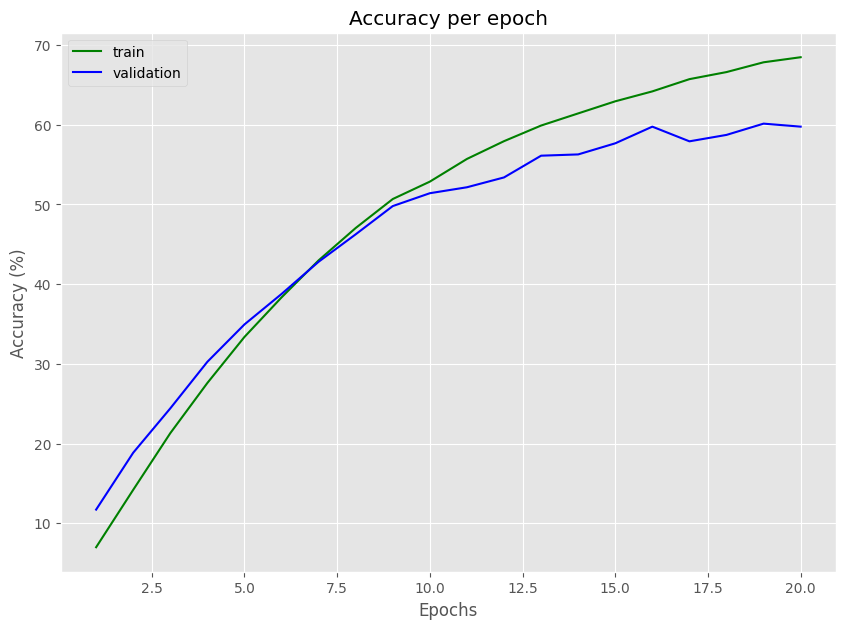

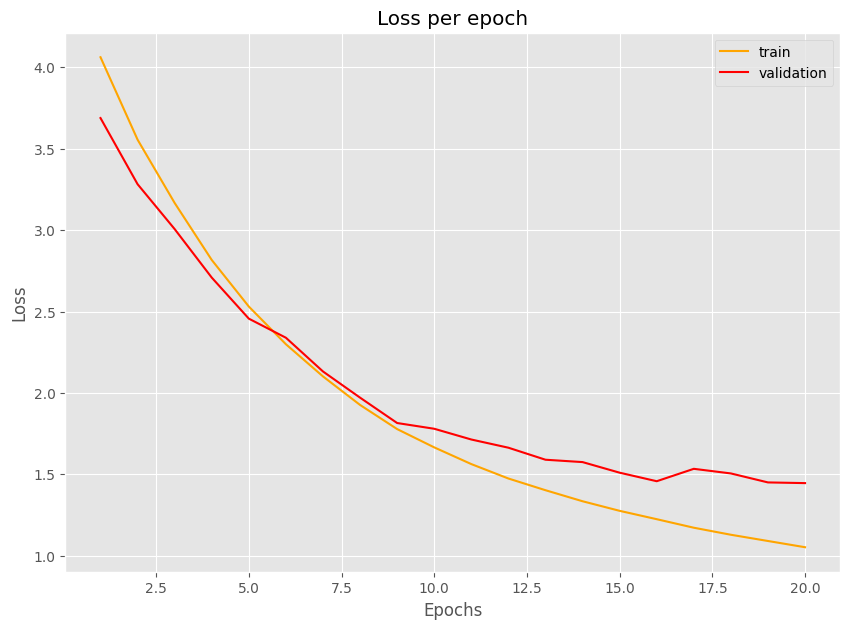

TRAINING FINISHED
CPU times: user 12min 33s, sys: 24.7 s, total: 12min 58s
Wall time: 17min 12s


In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='resnet18_custom',
      batch_size=batch_size, num_workers=num_workers, epochs=epochs,
      lr_scheduler=lr_scheduler,
      loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
      train_transform=train_transform, test_transform=test_transform,
      optim_code='_1359')

In [ ]:
!python test.py --num_classes 100 --cp_datetime '20240130_131908' --optim_code '_1359' --model_name 'resnet18_custom' --batch_size 64 --num_workers 2

Random seed 42 has been set.
Device: cuda

Random seed 42 has been set.
Device: cuda

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 32, 32]      [64, 100]            --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 64, 32, 32]     1,728                True
├─BatchNorm2d (bn1)                      [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
├─Sequential (layer1)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    └─BasicBlock (0)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    │    └─Conv2d (conv1)               [64, 64, 32, 32]     [64, 64, 32,

In [ ]:
# Hyperparameters (optim_code: _135i)
epochs = 30
l2 = 0.0001 # L2-norm for weight regularization (weight decay)
grad_clip = 0.1

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(), # p=0.5 by default, which means there's a 50% chance that the image will be horizontally flipped
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

Random seed 42 has been set.
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Epoch: 001/030 | Batch 001/625 | Loss: 1.9376
Epoch: 001/030 | Batch 121/625 | Loss: 2.2375
Epoch: 001/030 | Batch 241/625 | Loss: 1.9662
Epoch: 001/030 | Batch 361/625 | Loss: 2.5039
Epoch: 002/030 | Batch 121/625 | Loss: 2.0528
Epoch: 002/030 | Batch 241/625 | Loss: 2.3799
Epoch: 002/030 | Batch 361/625 | Loss: 2.3366
Epoch: 002/030 | Batch 481/625 | Loss: 2.0464
Epoch: 002/030 | Batch 601/625 | Loss: 2.1618
Epoch: 002/030   Train Loss: 1.9374 | Train Acc.: 46.55% | Validation Loss: 2.1272 | Validation Acc.: 43.89%
Validation loss decreased (2.1544 --> 2.1272).  Saving model for epoch 2...
--------------------------------------------------
Epoch: 003/030 | Batch 001/625 | Loss: 1.7731
Epoch: 003/030 | Batch 121/625 | Loss: 2.1841
Epoch: 003/030 | Batch 241/625 | Loss: 2.1801
Epoch: 003/030 | Batch 361/625 | Loss: 2.2339
Epoch: 003/030 | Batch 481/625 |

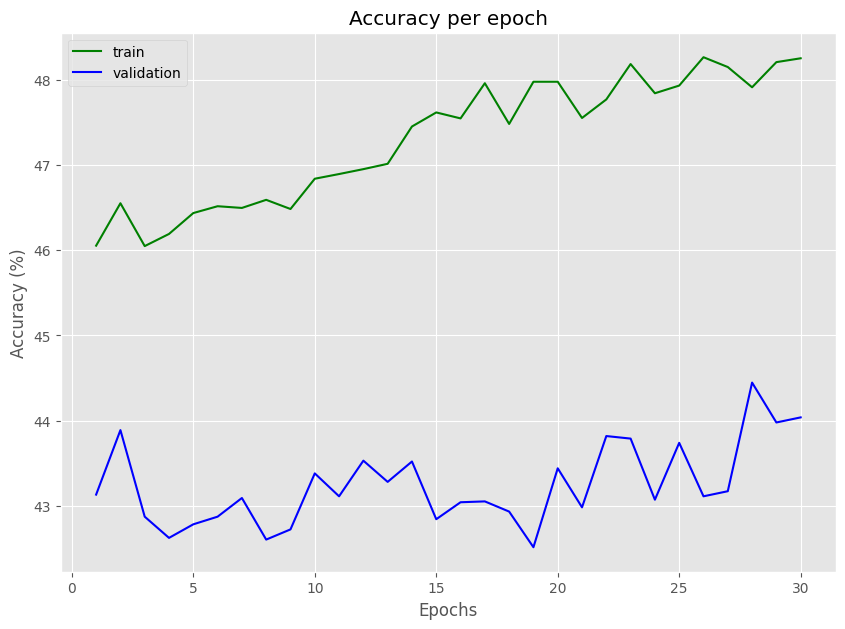

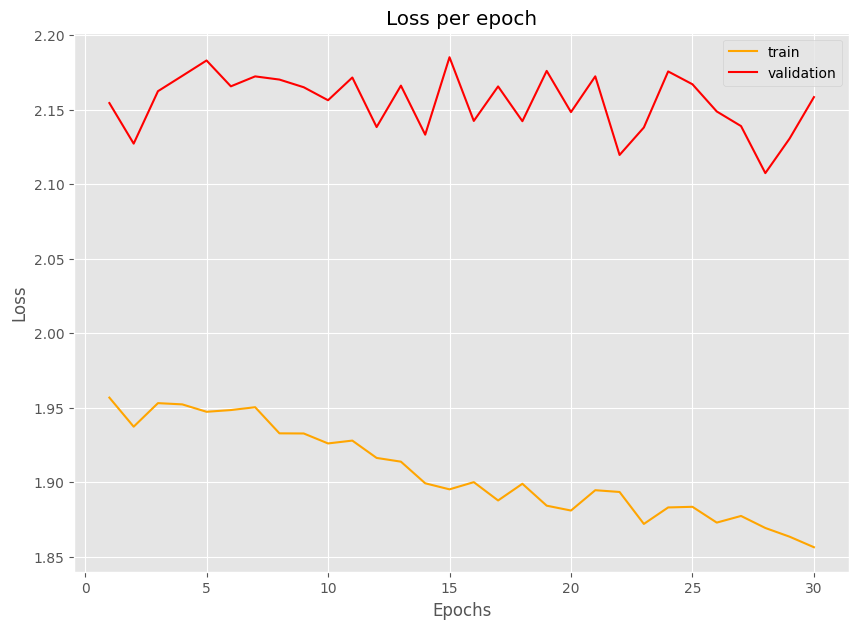

TRAINING FINISHED
CPU times: user 2min 26s, sys: 23.8 s, total: 2min 50s
Wall time: 10min 54s


In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='resnet18_custom',
      batch_size=batch_size, num_workers=num_workers, epochs=epochs,
      lr_scheduler=lr_scheduler,
      loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
      train_transform=train_transform, test_transform=test_transform,
      optim_code='_135i')

In [ ]:
!python test.py --num_classes 100 --cp_datetime '20240202_235134' --optim_code '_135i' --model_name 'resnet18_custom' --batch_size 64 --num_workers 2

Random seed 42 has been set.
Device: cuda

Random seed 42 has been set.
Device: cuda

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 32, 32]      [64, 100]            --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 64, 32, 32]     1,728                True
├─BatchNorm2d (bn1)                      [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
├─Sequential (layer1)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    └─BasicBlock (0)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    │    └─Conv2d (conv1)               [64, 64, 32, 32]     [64, 64, 32,

In [ ]:
# Hyperparameters (optim_code: _135j)
epochs = 50
l2 = 0.0001 # L2-norm for weight regularization (weight decay)
grad_clip = 0.1

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(), # p=0.5 by default, which means there's a 50% chance that the image will be horizontally flipped
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

In [ ]:
# Specify model
model = models.get_model('resnet18_custom', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
lr_scheduler = None

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 32, 32]      [64, 100]            --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 64, 32, 32]     1,728                True
├─BatchNorm2d (bn1)                      [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
├─Sequential (layer1)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    └─BasicBlock (0)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    │    └─Conv2d (conv1)               [64, 64, 32, 32]     [64, 64, 32, 32]     36,864               True
│    │    └─BatchNorm2d (bn1)            [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
│    │    └─Conv2d (conv2)               [64, 64, 32, 32]     [64, 64, 32, 32]     36,864               True
│    │    └─Ba

Random seed 42 has been set.
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Epoch: 001/050 | Batch 001/625 | Loss: 4.6601
Epoch: 001/050 | Batch 121/625 | Loss: 4.2919
Epoch: 001/050 | Batch 241/625 | Loss: 3.9412
Epoch: 001/050 | Batch 361/625 | Loss: 4.1640
Epoch: 001/050 | Batch 481/625 | Loss: 3.7491
Epoch: 001/050 | Batch 601/625 | Loss: 3.6611
Epoch: 001/050   Train Loss: 4.0524 | Train Acc.: 7.08% | Validation Loss: 3.7398 | Validation Acc.: 11.37%
Validation loss decreased (inf --> 3.7398).  Saving model for epoch 1...
--------------------------------------------------
Epoch: 002/050 | Batch 001/625 | Loss: 3.7564
Epoch: 002/050 | Batch 121/625 | Loss: 3.5811
Epoch: 002/050 | Batch 241/625 | Loss: 3.9599
Epoch: 002/050 | Batch 361/625 | Loss: 3.6525
Epoch: 002/050 | Batch 481/625 | Loss: 3.2727
Epoch: 002/050 | Batch 601/625 | Loss: 3.3501
Epoch: 002/050   Train Loss: 3.5705 | Train Acc.: 14.20% | Validation Loss: 3.3038

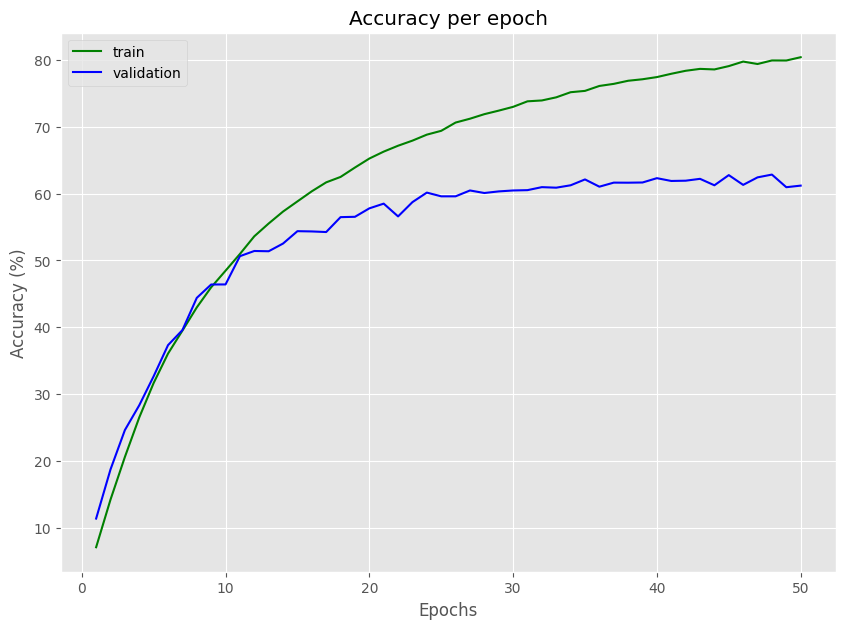

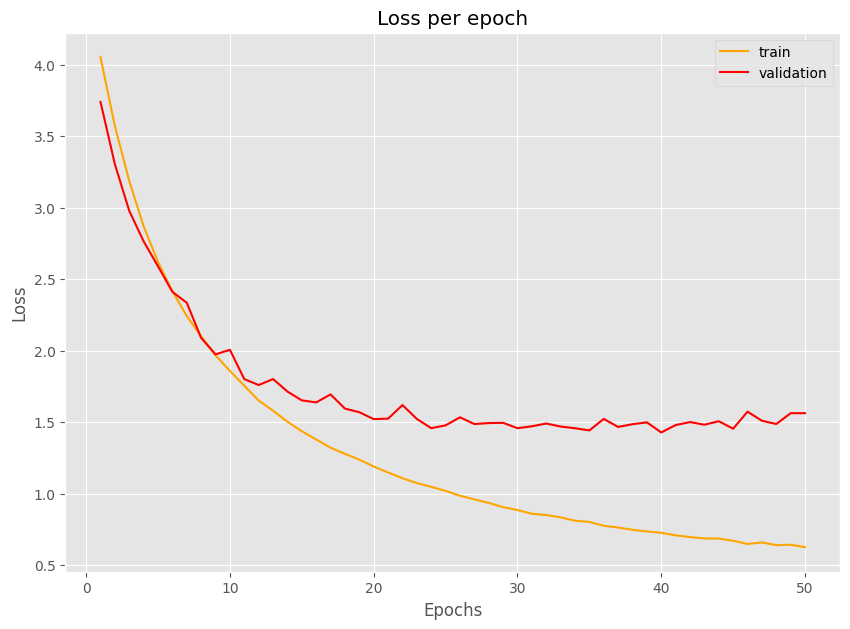

TRAINING FINISHED
CPU times: user 31min 50s, sys: 50.7 s, total: 32min 40s
Wall time: 40min 14s


In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='resnet18_custom',
      batch_size=batch_size, num_workers=num_workers, epochs=epochs,
      lr_scheduler=lr_scheduler,
      loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
      train_transform=train_transform, test_transform=test_transform,
      optim_code='_135j')

In [ ]:
!python test.py --num_classes 100 --cp_datetime '20240203_200259' --optim_code '_135j' --model_name 'resnet18_custom' --batch_size 64 --num_workers 2

Random seed 42 has been set.
Device: cuda

Random seed 42 has been set.
Device: cuda

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 32, 32]      [64, 100]            --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 64, 32, 32]     1,728                True
├─BatchNorm2d (bn1)                      [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
├─Sequential (layer1)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    └─BasicBlock (0)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    │    └─Conv2d (conv1)               [64, 64, 32, 32]     [64, 64, 32,

In [ ]:
# Hyperparameters (optim_code: _13hi)
epochs = 30
l2 = 0.0001 # L2-norm for weight regularization (weight decay)
grad_clip = 0.5

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(), # p=0.5 by default, which means there's a 50% chance that the image will be horizontally flipped
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

In [ ]:
# Specify model
model = models.get_model('resnet18_custom', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
lr_scheduler = None

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 32, 32]      [64, 100]            --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 64, 32, 32]     1,728                True
├─BatchNorm2d (bn1)                      [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
├─Sequential (layer1)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    └─BasicBlock (0)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    │    └─Conv2d (conv1)               [64, 64, 32, 32]     [64, 64, 32, 32]     36,864               True
│    │    └─BatchNorm2d (bn1)            [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
│    │    └─Conv2d (conv2)               [64, 64, 32, 32]     [64, 64, 32, 32]     36,864               True
│    │    └─Ba

Random seed 42 has been set.
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Epoch: 001/030 | Batch 001/625 | Loss: 4.6400
Epoch: 001/030 | Batch 121/625 | Loss: 4.2947
Epoch: 001/030 | Batch 241/625 | Loss: 3.9723
Epoch: 001/030 | Batch 361/625 | Loss: 4.1501
Epoch: 001/030 | Batch 481/625 | Loss: 3.7374
Epoch: 001/030 | Batch 601/625 | Loss: 3.7330
Epoch: 001/030   Train Loss: 4.0685 | Train Acc.: 6.96% | Validation Loss: 3.7441 | Validation Acc.: 11.09%
Validation loss decreased (inf --> 3.7441).  Saving model for epoch 1...
--------------------------------------------------
Epoch: 002/030 | Batch 001/625 | Loss: 3.7217
Epoch: 002/030 | Batch 121/625 | Loss: 3.6113
Epoch: 002/030 | Batch 241/625 | Loss: 3.9687
Epoch: 002/030 | Batch 361/625 | Loss: 3.4908
Epoch: 002/030 | Batch 481/625 | Loss: 3.2386
Epoch: 002/030 | Batch 601/625 | Loss: 3.4223
Epoch: 002/030   Train Loss: 3.5572 | Train Acc.: 14.34% | Validation Loss: 3.2915

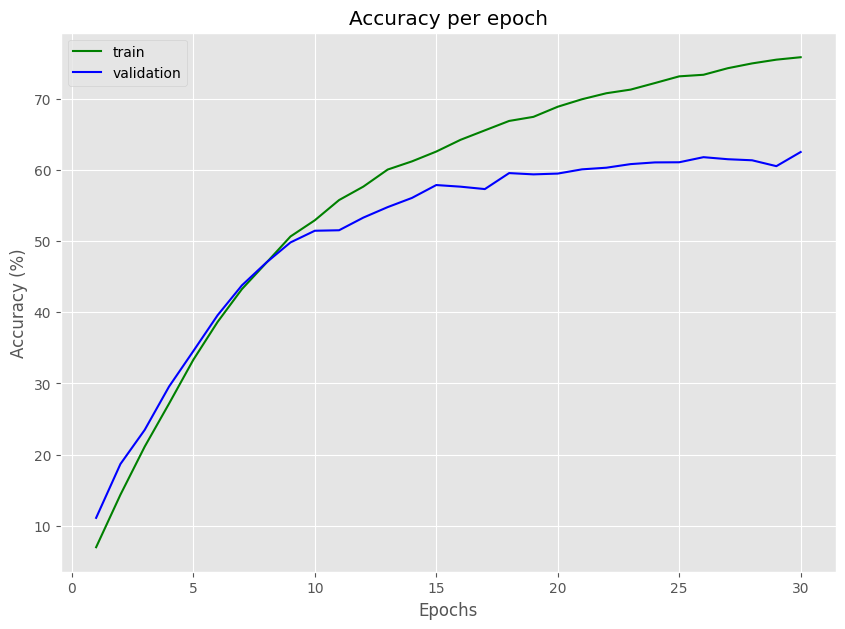

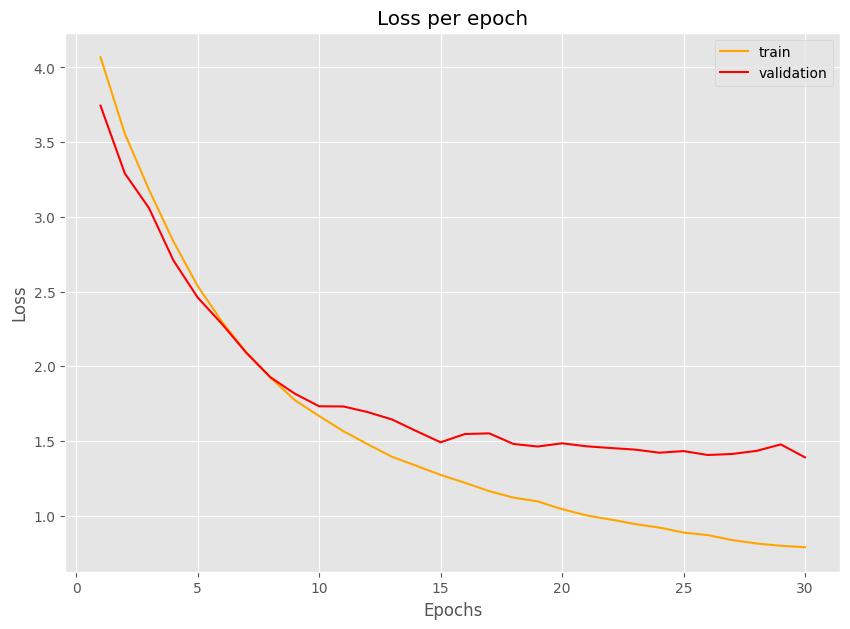

TRAINING FINISHED
CPU times: user 18min 53s, sys: 34.8 s, total: 19min 28s
Wall time: 25min 24s


In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='resnet18_custom',
      batch_size=batch_size, num_workers=num_workers, epochs=epochs,
      lr_scheduler=lr_scheduler,
      loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
      train_transform=train_transform, test_transform=test_transform,
      optim_code='_13hi')

In [ ]:
!python test.py --num_classes 100 --cp_datetime '20240130_134024' --optim_code '_13hi' --model_name 'resnet18_custom' --batch_size 64 --num_workers 2

Random seed 42 has been set.
Device: cuda

Random seed 42 has been set.
Device: cuda

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 32, 32]      [64, 100]            --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 64, 32, 32]     1,728                True
├─BatchNorm2d (bn1)                      [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
├─Sequential (layer1)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    └─BasicBlock (0)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    │    └─Conv2d (conv1)               [64, 64, 32, 32]     [64, 64, 32,

In [ ]:
# Hyperparameters (optim_code: _13hj)
epochs = 50
l2 = 0.0001 # L2-norm for weight regularization (weight decay)
grad_clip = 0.5

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(), # p=0.5 by default, which means there's a 50% chance that the image will be horizontally flipped
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

In [ ]:
# Specify model
model = models.get_model('resnet18_custom', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
lr_scheduler = None

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 32, 32]      [64, 100]            --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 64, 32, 32]     1,728                True
├─BatchNorm2d (bn1)                      [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
├─Sequential (layer1)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    └─BasicBlock (0)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    │    └─Conv2d (conv1)               [64, 64, 32, 32]     [64, 64, 32, 32]     36,864               True
│    │    └─BatchNorm2d (bn1)            [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
│    │    └─Conv2d (conv2)               [64, 64, 32, 32]     [64, 64, 32, 32]     36,864               True
│    │    └─Ba

Random seed 42 has been set.
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Epoch: 001/050 | Batch 001/625 | Loss: 4.7269
Epoch: 001/050 | Batch 121/625 | Loss: 4.3656
Epoch: 001/050 | Batch 241/625 | Loss: 3.7867
Epoch: 001/050 | Batch 361/625 | Loss: 4.1223
Epoch: 001/050 | Batch 481/625 | Loss: 3.6989
Epoch: 001/050 | Batch 601/625 | Loss: 3.7366
Epoch: 001/050   Train Loss: 3.9993 | Train Acc.: 8.06% | Validation Loss: 3.6906 | Validation Acc.: 12.40%
Validation loss decreased (inf --> 3.6906).  Saving model for epoch 1...
--------------------------------------------------
Epoch: 002/050 | Batch 001/625 | Loss: 3.6536
Epoch: 002/050 | Batch 121/625 | Loss: 3.5007
Epoch: 002/050 | Batch 241/625 | Loss: 3.7893
Epoch: 002/050 | Batch 361/625 | Loss: 3.5523
Epoch: 002/050 | Batch 481/625 | Loss: 3.2112
Epoch: 002/050 | Batch 601/625 | Loss: 3.3357
Epoch: 002/050   Train Loss: 3.4529 | Train Acc.: 16.39% | Validation Loss: 3.1529

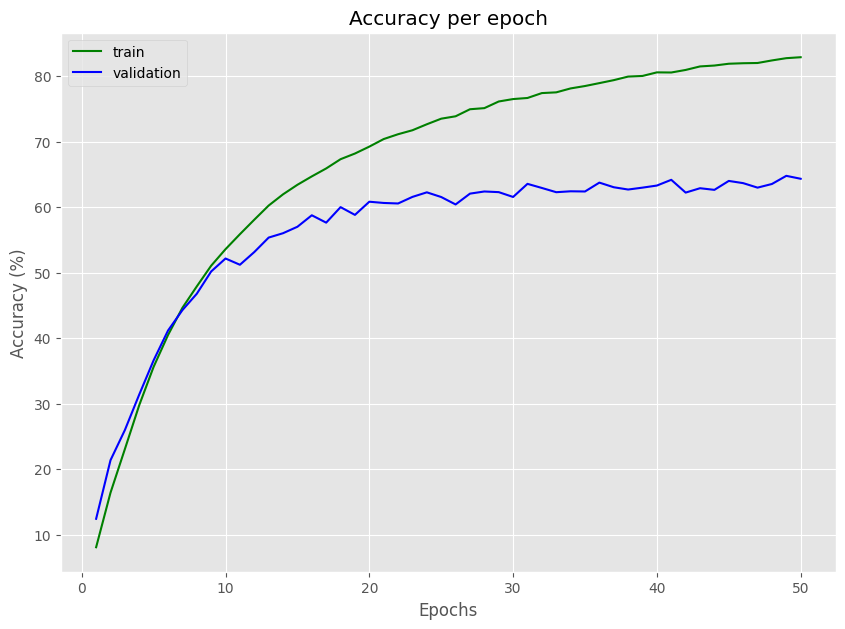

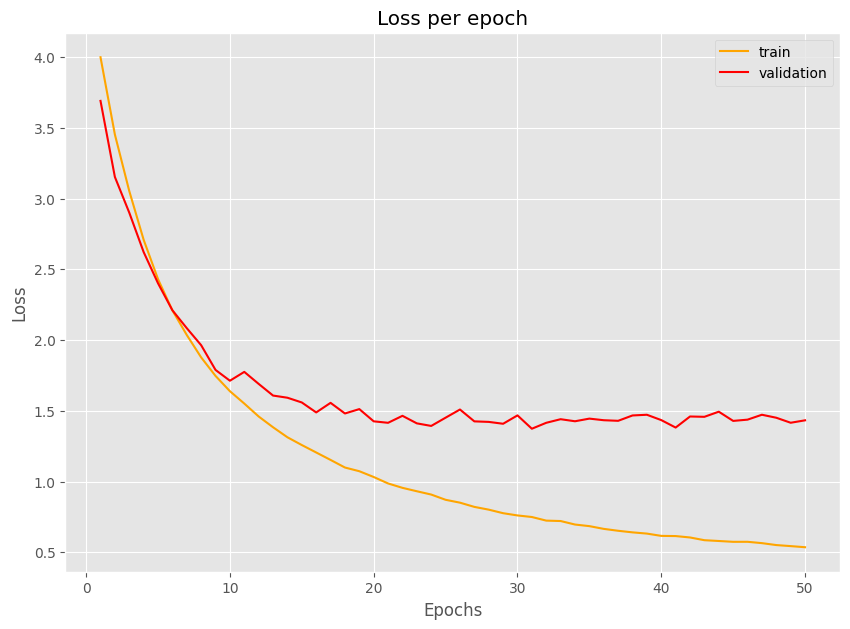

TRAINING FINISHED
CPU times: user 32min 30s, sys: 50.2 s, total: 33min 20s
Wall time: 40min 38s


In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='resnet18_custom',
      batch_size=batch_size, num_workers=num_workers, epochs=epochs,
      lr_scheduler=lr_scheduler,
      loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
      train_transform=train_transform, test_transform=test_transform,
      optim_code='_13hj')

In [ ]:
!python test.py --num_classes 100 --cp_datetime '20240223_112139' --optim_code '_13hj' --model_name 'resnet18_custom' --batch_size 64 --num_workers 2

Random seed 42 has been set.
Device: cuda

Random seed 42 has been set.
Device: cuda

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 32, 32]      [64, 100]            --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 64, 32, 32]     1,728                True
├─BatchNorm2d (bn1)                      [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
├─Sequential (layer1)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    └─BasicBlock (0)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    │    └─Conv2d (conv1)               [64, 64, 32, 32]     [64, 64, 32,

In [ ]:
# Old
!python test.py --num_classes 100 --cp_datetime '20240130_144942' --optim_code '_13hj' --model_name 'resnet18_custom' --batch_size 64 --num_workers 2

Random seed 42 has been set.
Device: cuda

Random seed 42 has been set.
Device: cuda

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 32, 32]      [64, 100]            --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 64, 32, 32]     1,728                True
├─BatchNorm2d (bn1)                      [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
├─Sequential (layer1)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    └─BasicBlock (0)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    │    └─Conv2d (conv1)               [64, 64, 32, 32]     [64, 64, 32,

In [ ]:
# Hyperparameters (optim_code: _2359c)
epochs = 20
lr = 0.0001
l2 = 0.0001 # L2-norm for weight regularization (weight decay)
grad_clip = 0.1

train_transform = transforms.Compose([
 transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

Random seed 42 has been set.
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Epoch: 001/020 | Batch 001/625 | Loss: 4.6435
Epoch: 001/020 | Batch 121/625 | Loss: 4.2915
Epoch: 001/020 | Batch 241/625 | Loss: 3.9782
Epoch: 001/020 | Batch 361/625 | Loss: 4.0828
Epoch: 001/020 | Batch 481/625 | Loss: 3.6538
Epoch: 001/020 | Batch 601/625 | Loss: 3.5387
Epoch: 001/020   Train Loss: 4.0665 | Train Acc.: 8.16% | Validation Loss: 3.7067 | Validation Acc.: 12.71%
Validation loss decreased (inf --> 3.7067).  Saving model for epoch 1...
--------------------------------------------------
Epoch: 002/020 | Batch 001/625 | Loss: 3.7137
Epoch: 002/020 | Batch 121/625 | Loss: 3.2423
Epoch: 002/020 | Batch 241/625 | Loss: 3.5132
Epoch: 002/020 | Batch 361/625 | Loss: 3.5118
Epoch: 002/020 | Batch 481/625 | Loss: 3.0059
Epoch: 002/020 | Batch 601/625 | Loss: 3.2321
Epoch: 002/020   Train Loss: 3.3576 | Train Acc.: 18.90% | Validation Loss: 3.1426

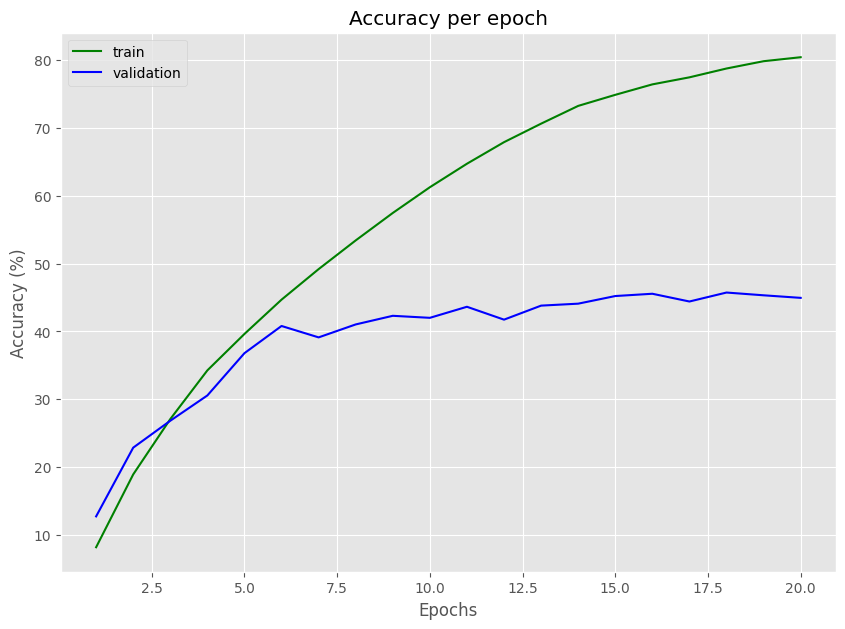

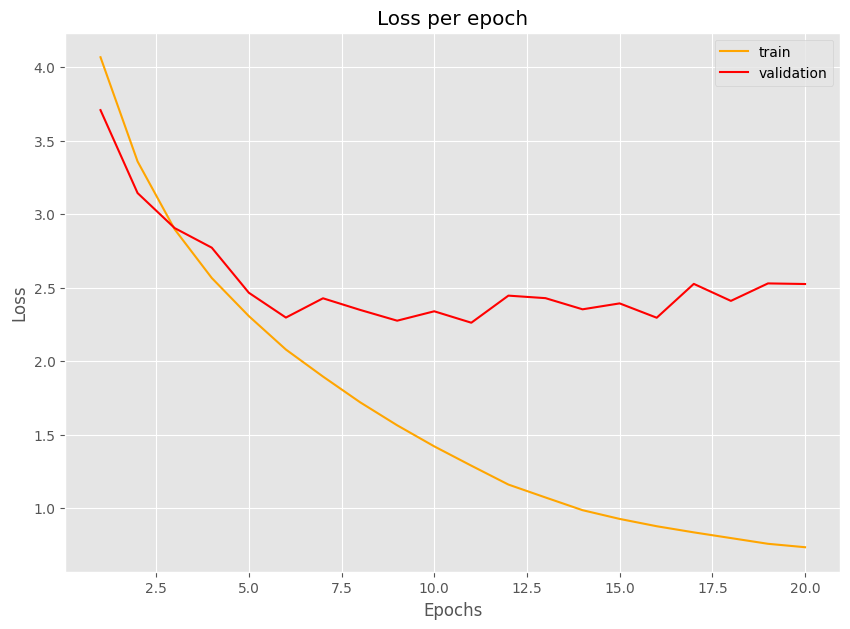

TRAINING FINISHED
CPU times: user 11min 44s, sys: 23.8 s, total: 12min 8s
Wall time: 19min 48s


In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='resnet18_custom',
      batch_size=batch_size, num_workers=num_workers, epochs=epochs,
      lr_scheduler=lr_scheduler,
      loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
      train_transform=train_transform, test_transform=test_transform,
      optim_code='_2359c')

In [ ]:
!python test.py --num_classes 100 --cp_datetime '20240130_122847' --optim_code '_2359c' --model_name 'resnet18_custom' --batch_size 64 --num_workers 2

Random seed 42 has been set.
Device: cuda

Random seed 42 has been set.
Device: cuda

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 32, 32]      [64, 100]            --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 64, 32, 32]     1,728                True
├─BatchNorm2d (bn1)                      [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
├─Sequential (layer1)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    └─BasicBlock (0)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    │    └─Conv2d (conv1)               [64, 64, 32, 32]     [64, 64, 32,

In [ ]:
# Hyperparameters (optim_code: _1359a)
epochs = 20
l2 = 0.0001 # L2-norm for weight regularization (weight decay)
grad_clip = 0.1

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(), # p=0.5 by default, which means there's a 50% chance that the image will be horizontally flipped
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

In [ ]:
# Specify model
model = models.get_model('resnet18_custom', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
lr_scheduler = None

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 32, 32]      [64, 100]            --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 64, 32, 32]     1,728                True
├─BatchNorm2d (bn1)                      [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
├─Sequential (layer1)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    └─BasicBlock (0)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    │    └─Conv2d (conv1)               [64, 64, 32, 32]     [64, 64, 32, 32]     36,864               True
│    │    └─BatchNorm2d (bn1)            [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
│    │    └─Conv2d (conv2)               [64, 64, 32, 32]     [64, 64, 32, 32]     36,864               True
│    │    └─Ba

Random seed 42 has been set.
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Epoch: 001/020 | Batch 001/625 | Loss: 4.6400
Epoch: 001/020 | Batch 121/625 | Loss: 4.4356
Epoch: 001/020 | Batch 241/625 | Loss: 4.0087
Epoch: 001/020 | Batch 361/625 | Loss: 4.1020
Epoch: 001/020 | Batch 481/625 | Loss: 3.7002
Epoch: 001/020 | Batch 601/625 | Loss: 3.5647
Epoch: 001/020   Train Loss: 4.0945 | Train Acc.: 7.55% | Validation Loss: 3.7027 | Validation Acc.: 12.73%
Validation loss decreased (inf --> 3.7027).  Saving model for epoch 1...
--------------------------------------------------
Epoch: 002/020 | Batch 001/625 | Loss: 3.6957
Epoch: 002/020 | Batch 121/625 | Loss: 3.6398
Epoch: 002/020 | Batch 241/625 | Loss: 3.7891
Epoch: 002/020 | Batch 361/625 | Loss: 3.5925
Epoch: 002/020 | Batch 481/625 | Loss: 3.3173
Epoch: 002/020 | Batch 601/625 | Loss: 3.4456
Epoch: 002/020   Train Loss: 3.5452 | Train Acc.: 14.88% | Validation Loss: 3.3121

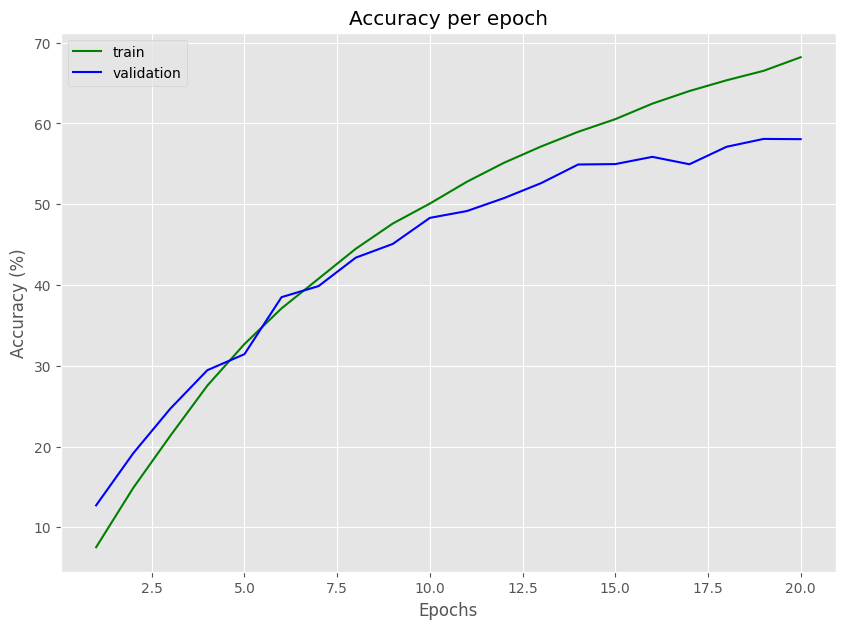

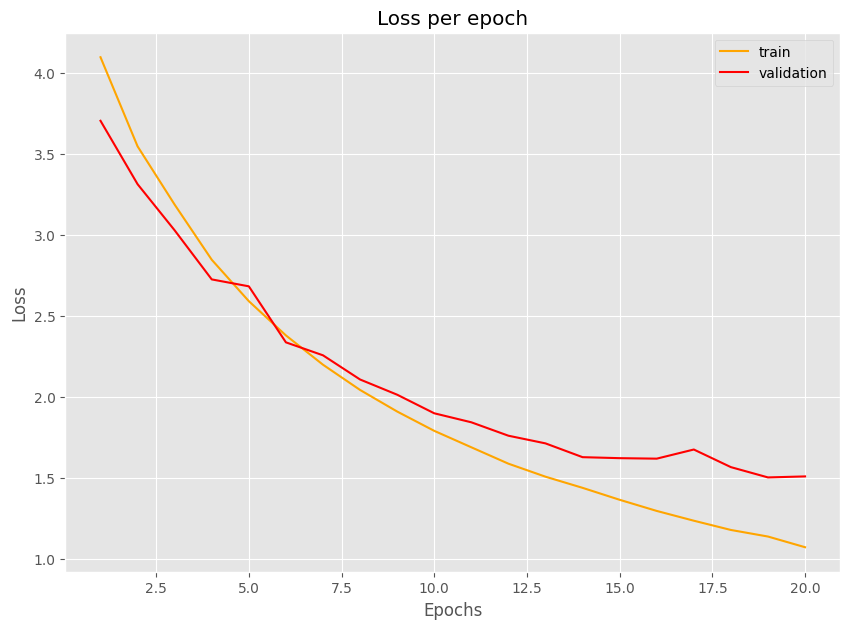

TRAINING FINISHED
CPU times: user 12min 12s, sys: 22.7 s, total: 12min 35s
Wall time: 16min 27s


In [ ]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='resnet18_custom',
      batch_size=batch_size, num_workers=num_workers, epochs=epochs,
      lr_scheduler=lr_scheduler,
      loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
      train_transform=train_transform, test_transform=test_transform,
      optim_code='_1359a')

In [ ]:
!python test.py --num_classes 100 --cp_datetime '20240130_125640' --optim_code '_1359a' --model_name 'resnet18_custom' --batch_size 64 --num_workers 2

Random seed 42 has been set.
Device: cuda

Random seed 42 has been set.
Device: cuda

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 32, 32]      [64, 100]            --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 64, 32, 32]     1,728                True
├─BatchNorm2d (bn1)                      [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
├─Sequential (layer1)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    └─BasicBlock (0)                    [64, 64, 32, 32]     [64, 64, 32, 32]     --                   True
│    │    └─Conv2d (conv1)               [64, 64, 32, 32]     [64, 64, 32,

## Train custom ResNet50

In [7]:
# Hyperparameters (optim_code: _1359)
epochs = 20
l2 = 0.0001 # L2-norm for weight regularization (weight decay)
grad_clip = 0.1

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(), # p=0.5 by default, which means there's a 50% chance that the image will be horizontally flipped
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

In [9]:
# Specify model
model = models.get_model('resnet50_custom', batch_size, num_classes)
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
lr_scheduler = None

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 32, 32]      [64, 100]            --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 64, 32, 32]     1,728                True
├─BatchNorm2d (bn1)                      [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
├─Sequential (layer1)                    [64, 64, 32, 32]     [64, 256, 32, 32]    --                   True
│    └─Bottleneck (0)                    [64, 64, 32, 32]     [64, 256, 32, 32]    --                   True
│    │    └─Conv2d (conv1)               [64, 64, 32, 32]     [64, 64, 32, 32]     4,096                True
│    │    └─BatchNorm2d (bn1)            [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
│    │    └─Conv2d (conv2)               [64, 64, 32, 32]     [64, 64, 32, 32]     36,864               True
│    │    └─Ba

Random seed 42 has been set.
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Epoch: 001/020 | Batch 001/625 | Loss: 4.7801
Epoch: 001/020 | Batch 121/625 | Loss: 4.4875
Epoch: 001/020 | Batch 241/625 | Loss: 4.1766
Epoch: 001/020 | Batch 361/625 | Loss: 4.3463
Epoch: 001/020 | Batch 481/625 | Loss: 3.9233
Epoch: 001/020 | Batch 601/625 | Loss: 3.6484
Epoch: 001/020   Train Loss: 4.2833 | Train Acc.: 4.40% | Validation Loss: 3.8611 | Validation Acc.: 9.05%
Validation loss decreased (inf --> 3.8611).  Saving model for epoch 1...
--------------------------------------------------
Epoch: 002/020 | Batch 001/625 | Loss: 3.8795
Epoch: 002/020 | Batch 121/625 | Loss: 3.8251
Epoch: 002/020 | Batch 241/625 | Loss: 4.0403
Epoch: 002/020 | Batch 361/625 | Loss: 3.9116
Epoch: 002/020 | Batch 481/625 | Loss: 3.4912
Epoch: 002/020 | Batch 601/625 | Loss: 3.6783
Epoch: 002/020   Train Loss: 3.7570 | Train Acc.: 10.46% | Validation Loss: 3.5642 

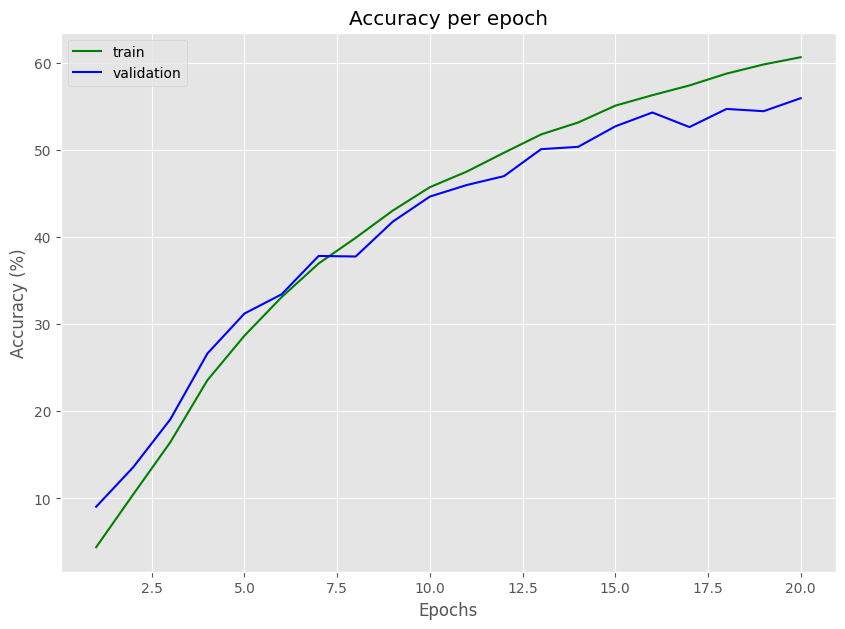

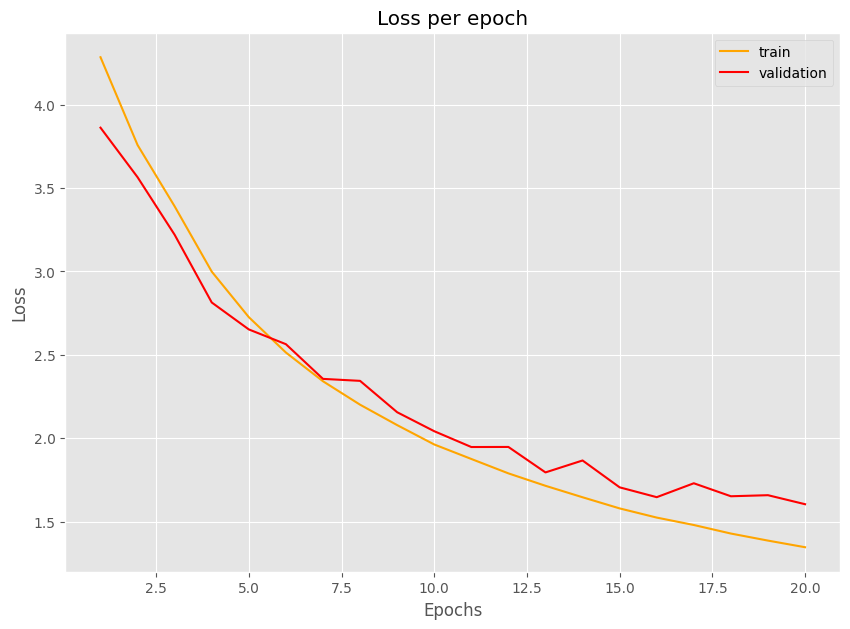

TRAINING FINISHED
CPU times: user 48min 6s, sys: 33.8 s, total: 48min 40s
Wall time: 51min 51s


In [10]:
%%time
from train import train

train(num_classes=num_classes, model=model, model_name='resnet50_custom',
      batch_size=batch_size, num_workers=num_workers, epochs=epochs,
      lr_scheduler=lr_scheduler,
      loss_func=loss_func, optimizer=optimizer, grad_clip=grad_clip,
      train_transform=train_transform, test_transform=test_transform,
      optim_code='_1359')


In [14]:
!python test.py --num_classes 100 --cp_datetime '20240224_231430' --optim_code '_1359' --model_name 'resnet50_custom' --batch_size 64 --num_workers 2

Random seed 42 has been set.
Device: cuda

Random seed 42 has been set.
Device: cuda

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Random seed 42 has been set.
Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 32, 32]      [64, 100]            --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 64, 32, 32]     1,728                True
├─BatchNorm2d (bn1)                      [64, 64, 32, 32]     [64, 64, 32, 32]     128                  True
├─Sequential (layer1)                    [64, 64, 32, 32]     [64, 256, 32, 32]    --                   True
│    └─Bottleneck (0)                    [64, 64, 32, 32]     [64, 256, 32, 32]    --                   True
│    │    └─Conv2d (conv1)               [64, 64, 32, 32]     [64, 64, 32,